In [0]:
# Import requirements
import zipfile
import json
import numpy as np
import pandas as pd
import zipfile 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import scale
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn import datasets, metrics
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
import umap
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix



!pip install kaggle
!mkdir .kaggle

In [0]:
# Define confusion matrix function
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [0]:
# Download Kaggle Dataset
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d ranja7/vehicle-insurance-customer-data

  0% 0.00/346k [00:00<?, ?B/s]
100% 346k/346k [00:00<00:00, 41.9MB/s]
vehicle-insurance-customer-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
# Unzip the newly downloaded file
zipref = zipfile.ZipFile('vehicle-insurance-customer-data.zip', 'r')
zipref.extractall()
zipref.close()

In [0]:
# Output the directory of the unizipped file as to find where the dataset is located
zipref.printdir()

File Name                                             Modified             Size
AutoInsurance.csv                              2019-10-24 18:40:28      1589254


In [0]:
# Read the csv and declare it as our new dataframr
df = pd.read_csv("AutoInsurance.csv")

In [0]:
# Drop arbitrary features that deal with identification 
df = df.drop(['Customer', 'Effective To Date'], axis=1)

In [0]:
# Identify which features are non-numeric
str_columns = df.select_dtypes(['object']).columns
print(str_columns)

Index(['State', 'Response', 'Coverage', 'Education', 'EmploymentStatus',
       'Gender', 'Location Code', 'Marital Status', 'Policy Type', 'Policy',
       'Renew Offer Type', 'Sales Channel', 'Vehicle Class', 'Vehicle Size'],
      dtype='object')


In [0]:
# Identify which features are numeric
num_columns = df.select_dtypes(['int64', 'float64']).columns
print(num_columns)

Index(['Customer Lifetime Value', 'Income', 'Monthly Premium Auto',
       'Months Since Last Claim', 'Months Since Policy Inception',
       'Number of Open Complaints', 'Number of Policies',
       'Total Claim Amount'],
      dtype='object')


In [0]:
# Check to see if there are any missing values in the dataset
missing_total = df.isnull().sum().sort_values(ascending=False)
percent_missing = (missing_total/df.isnull().count())
percent_missing.sort_values(ascending=False)

Vehicle Size                     0.0
Vehicle Class                    0.0
Customer Lifetime Value          0.0
Education                        0.0
EmploymentStatus                 0.0
Gender                           0.0
Income                           0.0
Location Code                    0.0
Marital Status                   0.0
Monthly Premium Auto             0.0
Months Since Last Claim          0.0
Months Since Policy Inception    0.0
Number of Open Complaints        0.0
Number of Policies               0.0
Policy                           0.0
Policy Type                      0.0
Renew Offer Type                 0.0
Response                         0.0
Sales Channel                    0.0
State                            0.0
Total Claim Amount               0.0
Coverage                         0.0
dtype: float64

In [0]:
# Before converting all non-numeric features to dummys, check to see what the distribution
# over each feature
noise = []

for column in str_columns: 
  print("In {} the distribution over responses is: {}".format(column, df[column].unique()))
  for response in df[column].unique(): 
    print("{} has {} outcomes or {} %".format(response, (df[column]==response).sum(), (df[column]==response).sum()/len(df)))
    # Drop all labels that apply to less than 5% of the population
    if (df[column]==response).sum()/len(df) < .025:
      noise = np.append(noise, response)
      df = df[df[column] != response]
  print("-------------------------------------------------------------------------------")

# Output which observations we are considering noise and removing from the model
noise

In State the distribution over responses is: ['Washington' 'Arizona' 'Nevada' 'California' 'Oregon']
Washington has 798 outcomes or 0.08736588570177359 %
Arizona has 1703 outcomes or 0.18644624479964966 %
Nevada has 882 outcomes or 0.09656229472301292 %
California has 3150 outcomes or 0.3448653382964747 %
Oregon has 2601 outcomes or 0.2847602364790891 %
-------------------------------------------------------------------------------
In Response the distribution over responses is: ['No' 'Yes']
No has 7826 outcomes or 0.8567987738121305 %
Yes has 1308 outcomes or 0.14320122618786948 %
-------------------------------------------------------------------------------
In Coverage the distribution over responses is: ['Basic' 'Extended' 'Premium']
Basic has 5568 outcomes or 0.6095905408364353 %
Extended has 2742 outcomes or 0.300197065907598 %
Premium has 824 outcomes or 0.09021239325596672 %
-------------------------------------------------------------------------------
In Education the distrib

array(['Special L2', 'Special L1', 'Special L3', 'Luxury SUV',
       'Luxury Car'], dtype='<U32')

In [0]:
# Convert non-numeric features into dummy variables
for column in str_columns: 
  df = pd.concat([df,pd.get_dummies(df[column], prefix="{}".format(column), drop_first=True)], axis=1)

# Drop the former non-numeric features and retain their dummy variables
df = df.drop(str_columns, axis=1)

In [0]:
# Reset the index after dropping noisy observations
df.reset_index()

,index,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,State_California,State_Nevada,State_Oregon,State_Washington,Response_Yes,Coverage_Extended,Coverage_Premium,Education_College,Education_Doctor,Education_High School or Below,Education_Master,EmploymentStatus_Employed,EmploymentStatus_Medical Leave,EmploymentStatus_Retired,EmploymentStatus_Unemployed,Gender_M,Location Code_Suburban,Location Code_Urban,Marital Status_Married,Marital Status_Single,Policy Type_Personal Auto,Policy_Corporate L2,Policy_Corporate L3,Policy_Personal L1,Policy_Personal L2,Policy_Personal L3,Renew Offer Type_Offer2,Renew Offer Type_Offer3,Renew Offer Type_Offer4,Sales Channel_Branch,Sales Channel_Call Center,Sales Channel_Web,Vehicle Class_SUV,Vehicle Class_Sports Car,Vehicle Class_Two-Door Car,Vehicle Size_Medsize,Vehicle Size_Small
0,0,2763.519279,56274,69,32,5,0,1,384.811147,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,1,6979.535903,0,94,13,42,0,8,1131.464935,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
2,2,12887.431650,48767,108,18,38,0,2,566.472247,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0
3,3,7645.861827,0,106,18,65,0,7,529.881344,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0
4,4,2813.692575,43836,73,12,44,0,1,138.130879,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8417,9129,23405.987980,71941,73,18,89,0,2,198.234764,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0
8418,9130,3096.511217,21604,79,14,28,0,1,379.200000,1,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
8419,9131,8163.890428,0,85,9,37,3,2,790.784983,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
8420,9132,7524.442436,21941,96,34,3,0,3,691.200000,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0


In [0]:
# Describe data
df.describe()

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,State_California,State_Nevada,State_Oregon,State_Washington,Response_Yes,Coverage_Extended,Coverage_Premium,Education_College,Education_Doctor,Education_High School or Below,Education_Master,EmploymentStatus_Employed,EmploymentStatus_Medical Leave,EmploymentStatus_Retired,EmploymentStatus_Unemployed,Gender_M,Location Code_Suburban,Location Code_Urban,Marital Status_Married,Marital Status_Single,Policy Type_Personal Auto,Policy_Corporate L2,Policy_Corporate L3,Policy_Personal L1,Policy_Personal L2,Policy_Personal L3,Renew Offer Type_Offer2,Renew Offer Type_Offer3,Renew Offer Type_Offer4,Sales Channel_Branch,Sales Channel_Call Center,Sales Channel_Web,Vehicle Class_SUV,Vehicle Class_Sports Car,Vehicle Class_Two-Door Car,Vehicle Size_Medsize,Vehicle Size_Small
count,8422.000000,8422.000000,8422.000000,8422.000000,8422.000000,8422.000000,8422.000000,8422.000000,8422.000000,8422.000000,8422.000000,8422.000000,8422.000000,8422.000000,8422.000000,8422.000000,8422.000000,8422.000000,8422.000000,8422.000000,8422.000000,8422.000000,8422.000000,8422.000000,8422.000000,8422.000000,8422.000000,8422.000000,8422.000000,8422.000000,8422.000000,8422.000000,8422.000000,8422.000000,8422.000000,8422.000000,8422.000000,8422.000000,8422.000000,8422.000000,8422.000000,8422.000000,8422.000000,8422.000000,8422.000000
mean,7615.428505,37600.837093,88.484802,15.100689,48.015436,0.383519,2.971384,407.084775,0.346948,0.096533,0.282356,0.087746,0.143196,0.298148,0.088578,0.293754,0.038233,0.284968,0.081453,0.622417,0.047970,0.031346,0.253978,0.488483,0.628354,0.174424,0.581216,0.267395,0.774875,0.067442,0.116718,0.140703,0.243885,0.390287,0.322251,0.156732,0.111137,0.280931,0.195915,0.143196,0.204464,0.054500,0.215744,0.705296,0.190691
std,6257.037116,30400.884539,24.670616,10.070813,27.975072,0.909465,2.395075,242.809310,0.476027,0.295338,0.450172,0.282942,0.350294,0.457472,0.284150,0.455508,0.191770,0.451426,0.273546,0.484811,0.213715,0.174263,0.435311,0.499897,0.483273,0.379496,0.493389,0.442626,0.417689,0.250802,0.321103,0.347735,0.429450,0.487844,0.467366,0.363570,0.314321,0.449480,0.396927,0.350294,0.403334,0.227015,0.411362,0.455937,0.392869
min,1898.007675,0.000000,61.000000,0.000000,0.000000,0.000000,1.000000,0.099007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3885.456401,0.000000,68.000000,6.000000,24.000000,0.000000,1.000000,263.830385,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5607.704658,33746.000000,81.000000,14.000000,48.000000,0.000000,2.000000,371.157204,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,8672.659264,62287.500000,106.000000,23.000000,71.000000,0.000000,4.000000,529.500665,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000


In [0]:
# Create an absoute valued correlation matrix
abs_corr_matrix = df.corr().abs()

# Select the upper triangle of the correlation matrix
upper = abs_corr_matrix.where(np.triu(np.ones(abs_corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

# Check to see if any features appeared highly correlated
print("This is a list of highly correlated features that must be dropped {}: ".format(to_drop))

# Drop these features from the dataset (Even though there doesn't appear to be any)
df.drop(df[to_drop], axis=1)

This is a list of highly correlated features that must be dropped []: 


,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,State_California,State_Nevada,State_Oregon,State_Washington,Response_Yes,Coverage_Extended,Coverage_Premium,Education_College,Education_Doctor,Education_High School or Below,Education_Master,EmploymentStatus_Employed,EmploymentStatus_Medical Leave,EmploymentStatus_Retired,EmploymentStatus_Unemployed,Gender_M,Location Code_Suburban,Location Code_Urban,Marital Status_Married,Marital Status_Single,Policy Type_Personal Auto,Policy_Corporate L2,Policy_Corporate L3,Policy_Personal L1,Policy_Personal L2,Policy_Personal L3,Renew Offer Type_Offer2,Renew Offer Type_Offer3,Renew Offer Type_Offer4,Sales Channel_Branch,Sales Channel_Call Center,Sales Channel_Web,Vehicle Class_SUV,Vehicle Class_Sports Car,Vehicle Class_Two-Door Car,Vehicle Size_Medsize,Vehicle Size_Small
0,2763.519279,56274,69,32,5,0,1,384.811147,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,6979.535903,0,94,13,42,0,8,1131.464935,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
2,12887.431650,48767,108,18,38,0,2,566.472247,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0
3,7645.861827,0,106,18,65,0,7,529.881344,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0
4,2813.692575,43836,73,12,44,0,1,138.130879,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9129,23405.987980,71941,73,18,89,0,2,198.234764,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0
9130,3096.511217,21604,79,14,28,0,1,379.200000,1,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
9131,8163.890428,0,85,9,37,3,2,790.784983,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
9132,7524.442436,21941,96,34,3,0,3,691.200000,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0


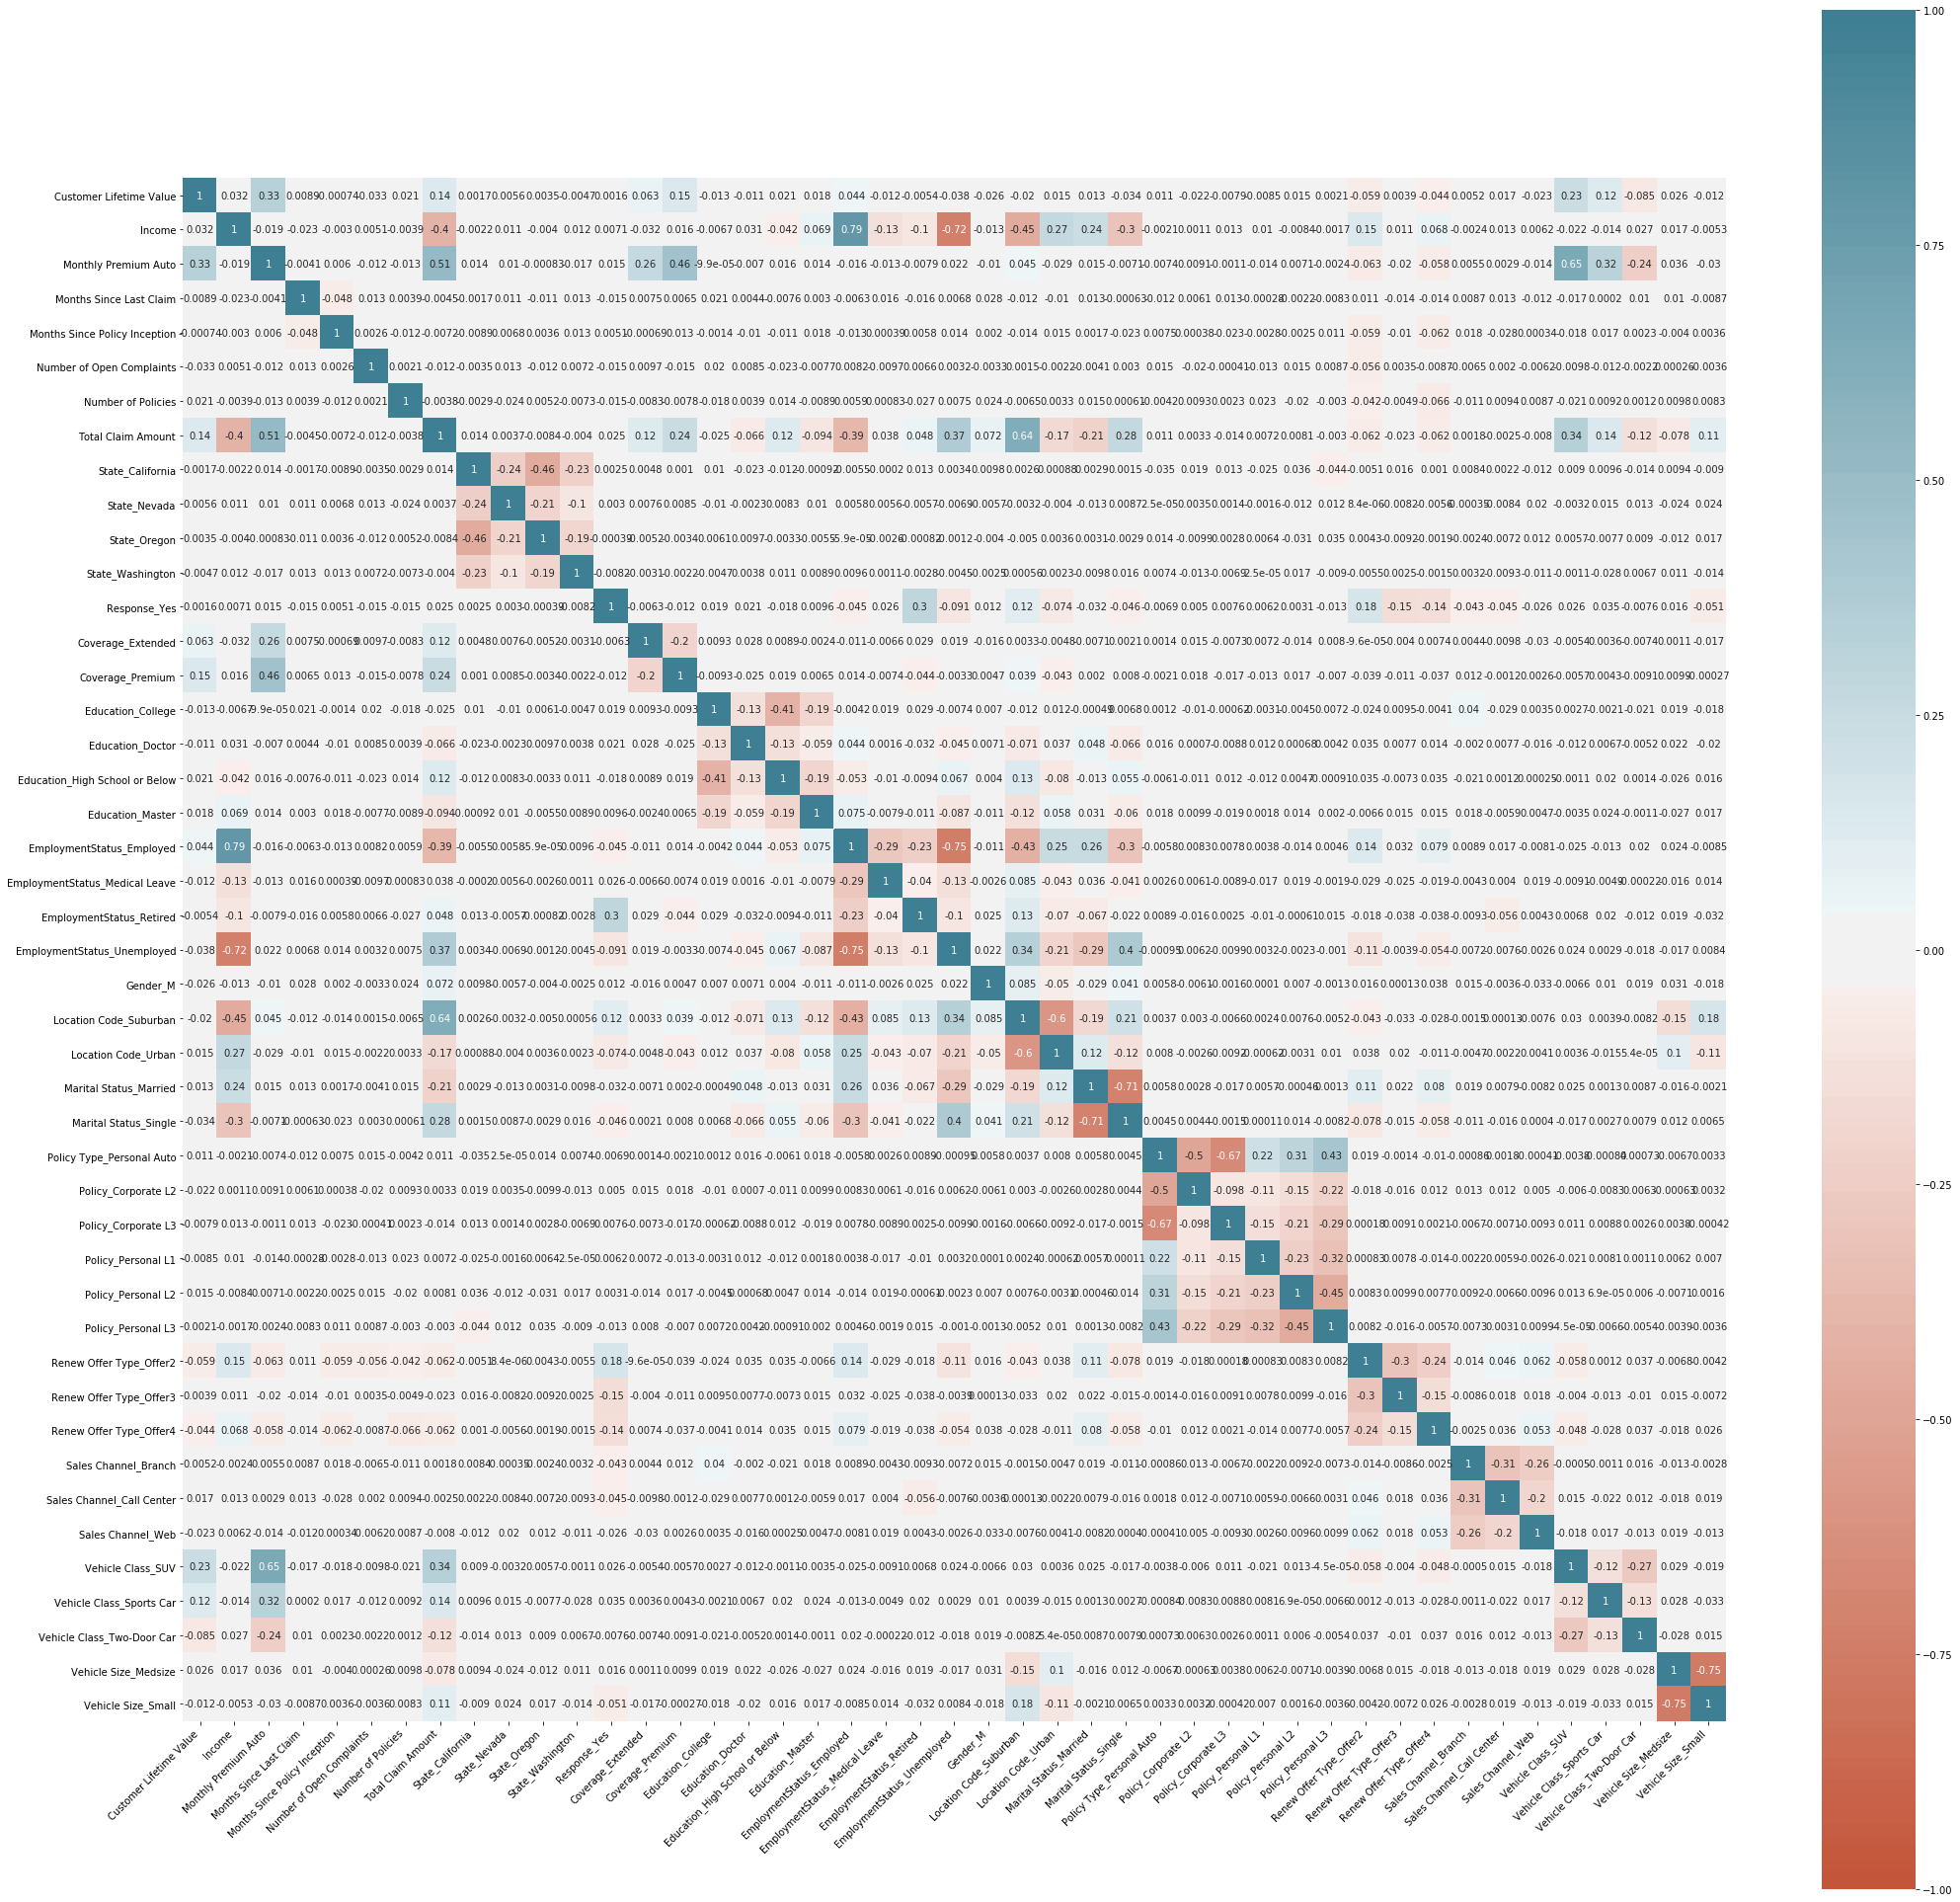

In [0]:
# Visualize the correlation matrix
df_corr = df.corr(method ='pearson')

plt.figure(figsize=(35,35))
ax = sns.heatmap(
    df_corr, 
    annot=True,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [0]:
# Standardize and winsorize each column in order to prepare them for dimentionality reduction & clustering
for column in df.columns:
  df[column] = scale(df[column])
  df[column] = winsorize(df[column], limits=0.15)

In [0]:
# Output the clean, reset, final dataframe
df.reset_index(drop=True)

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,State_California,State_Nevada,State_Oregon,State_Washington,Response_Yes,Coverage_Extended,Coverage_Premium,Education_College,Education_Doctor,Education_High School or Below,Education_Master,EmploymentStatus_Employed,EmploymentStatus_Medical Leave,EmploymentStatus_Retired,EmploymentStatus_Unemployed,Gender_M,Location Code_Suburban,Location Code_Urban,Marital Status_Married,Marital Status_Single,Policy Type_Personal Auto,Policy_Corporate L2,Policy_Corporate L3,Policy_Personal L1,Policy_Personal L2,Policy_Personal L3,Renew Offer Type_Offer2,Renew Offer Type_Offer3,Renew Offer Type_Offer4,Sales Channel_Branch,Sales Channel_Call Center,Sales Channel_Web,Vehicle Class_SUV,Vehicle Class_Sports Car,Vehicle Class_Two-Door Car,Vehicle Size_Medsize,Vehicle Size_Small
0,-0.759622,0.614267,-0.789845,1.280937,-1.215992,-0.421723,-0.823148,-0.091738,-0.728885,-0.326875,-0.627254,-0.310139,-0.408814,-0.651768,-0.311747,-0.644933,-0.199382,-0.631299,-0.297786,0.778870,-0.22447,-0.179891,-0.583474,-0.977224,0.769064,-0.459647,0.848841,-0.604146,-1.855258,-0.268923,-0.363513,-0.40465,-0.567935,-0.800073,-0.689546,-0.431118,-0.353601,-0.625050,-0.493609,-0.408814,-0.506966,-0.240087,1.906597,0.646409,-0.485409
1,-0.101634,-1.236907,0.223567,-0.208604,-0.215041,-0.421723,1.264593,0.903294,-0.728885,-0.326875,-0.627254,-0.310139,-0.408814,1.534289,-0.311747,-0.644933,-0.199382,-0.631299,-0.297786,-1.283911,-0.22447,-0.179891,1.713871,-0.977224,0.769064,-0.459647,-1.178077,1.655230,0.539009,-0.268923,-0.363513,-0.40465,-0.567935,1.249886,-0.689546,2.319548,-0.353601,-0.625050,-0.493609,-0.408814,-0.506966,-0.240087,-0.524495,0.646409,-0.485409
2,0.610709,0.367319,0.791077,0.287910,-0.358034,-0.421723,-0.405600,0.656470,-0.728885,-0.326875,-0.627254,-0.310139,-0.408814,-0.651768,-0.311747,-0.644933,-0.199382,-0.631299,-0.297786,0.778870,-0.22447,-0.179891,-0.583474,-0.977224,0.769064,-0.459647,0.848841,-0.604146,0.539009,-0.268923,-0.363513,-0.40465,-0.567935,1.249886,-0.689546,-0.431118,-0.353601,-0.625050,-0.493609,-0.408814,-0.506966,-0.240087,1.906597,0.646409,-0.485409
3,0.004864,-1.236907,0.710004,0.287910,0.607168,-0.421723,1.264593,0.505763,1.371959,-0.326875,-0.627254,-0.310139,-0.408814,-0.651768,-0.311747,-0.644933,-0.199382,-0.631299,-0.297786,-1.283911,-0.22447,-0.179891,1.713871,1.023306,0.769064,-0.459647,0.848841,-0.604146,-1.855258,-0.268923,-0.363513,-0.40465,-0.567935,-0.800073,-0.689546,-0.431118,-0.353601,-0.625050,2.025893,-0.408814,1.972517,-0.240087,-0.524495,0.646409,-0.485409
4,-0.759622,0.205110,-0.627699,-0.307907,-0.143545,-0.421723,-0.823148,-1.052468,-0.728885,-0.326875,-0.627254,-0.310139,-0.408814,-0.651768,-0.311747,-0.644933,-0.199382,-0.631299,-0.297786,0.778870,-0.22447,-0.179891,-0.583474,1.023306,-1.300283,-0.459647,-1.178077,1.655230,0.539009,-0.268923,-0.363513,-0.40465,-0.567935,-0.800073,-0.689546,-0.431118,-0.353601,-0.625050,-0.493609,-0.408814,-0.506966,-0.240087,-0.524495,0.646409,-0.485409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8417,0.610709,1.129645,-0.627699,0.287910,1.214888,-0.421723,-0.405600,-0.860191,1.371959,-0.326875,-0.627254,-0.310139,-0.408814,-0.651768,-0.311747,-0.644933,-0.199382,-0.631299,-0.297786,0.778870,-0.22447,-0.179891,-0.583474,1.023306,-1.300283,2.175581,0.848841,-0.604146,0.539009,-0.268923,-0.363513,-0.40465,-0.567935,-0.800073,1.450231,-0.431118,-0.353601,-0.625050,-0.493609,-0.408814,-0.506966,-0.240087,-0.524495,0.646409,-0.485409
8418,-0.722256,-0.526228,-0.384480,-0.109301,-0.715516,-0.421723,-0.823148,-0.114849,1.371959,-0.326875,-0.627254,-0.310139,-0.408814,1.534289,-0.311747,1.550549,-0.199382,-0.631299,-0.297786,0.778870,-0.22447,-0.179891,-0.583474,-0.977

Now that I have cleaned my data, I will begin to use various clustering techniques to locate similarities between my observations in higher dimentions.


K-Means Clustering

In [0]:
# K-Means Approach
efficiency_no_batch = []

for i in range(2,16): 
  k_means = KMeans(n_clusters=i)
  pred_y_no_batch = k_means.fit_predict(df)
  efficiency = metrics.silhouette_score(df, pred_y_no_batch, metric='manhattan')
  efficiency_no_batch = np.append(efficiency_no_batch, efficiency)
  print("With {} means, the silhoutte score is {}".format(i, efficiency))
  print("--------------------------------------------------------------------")

With 2 means, the silhoutte score is 0.17330713699463182
--------------------------------------------------------------------
With 3 means, the silhoutte score is 0.1352198227168218
--------------------------------------------------------------------
With 4 means, the silhoutte score is 0.12750461697453158
--------------------------------------------------------------------
With 5 means, the silhoutte score is 0.11916182013372074
--------------------------------------------------------------------
With 6 means, the silhoutte score is 0.10949813839960211
--------------------------------------------------------------------
With 7 means, the silhoutte score is 0.11800770674003493
--------------------------------------------------------------------
With 8 means, the silhoutte score is 0.10976586566701207
--------------------------------------------------------------------
With 9 means, the silhoutte score is 0.10044777349643262
--------------------------------------------------------------

In [0]:
# Mini Batch K-Means Approach

efficiency_with_batch = []

for i in range(2,16): 
  mini_means = MiniBatchKMeans(n_clusters=i)
  pred_y_with_batch = mini_means.fit_predict(df)
  efficiency = metrics.silhouette_score(df, pred_y_with_batch, metric='manhattan')
  efficiency_with_batch = np.append(efficiency_with_batch, efficiency)
  print("With {} means, the silhoutte score is {}".format(i, efficiency))
  print("--------------------------------------------------------------------")

With 2 means, the silhoutte score is 0.17178272601812117
--------------------------------------------------------------------
With 3 means, the silhoutte score is 0.13430364799083863
--------------------------------------------------------------------
With 4 means, the silhoutte score is 0.11922292800144366
--------------------------------------------------------------------
With 5 means, the silhoutte score is 0.1128398951074322
--------------------------------------------------------------------
With 6 means, the silhoutte score is 0.10303829079744517
--------------------------------------------------------------------
With 7 means, the silhoutte score is 0.08798333006675045
--------------------------------------------------------------------
With 8 means, the silhoutte score is 0.07603084464824168
--------------------------------------------------------------------
With 9 means, the silhoutte score is 0.08648934509810441
--------------------------------------------------------------

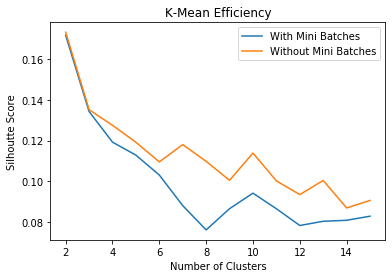

In [0]:
# Plot a graph showing the relationship between K-Means With & Without Batches
plt.plot(range(2,16), efficiency_with_batch, label = 'With Mini Batches')
plt.plot(range(2,16), efficiency_no_batch, label = 'Without Mini Batches')
plt.ylabel("Silhoutte Score")
plt.xlabel("Number of Clusters")
plt.title("K-Mean Efficiency")
plt.legend()
plt.show()

Both clusters perform rather similarly and have their highest silhoutte score at k=2. Regardless of the number of clusters, the model without mini-batching seems to perform better over all. I will use this model to assess the characteristics of each cluster. 

In [0]:
# Fit our KMeans model with k=2
k_means = KMeans(n_clusters=2)
k_means_pred = k_means.fit_predict(df)
kmeans = pd.DataFrame(k_means_pred)

# Add the predicted clusters to the dataframe
df_with_kmeans = df.reset_index(drop=True)
df_with_kmeans["K Means Prediction"] = kmeans
df_with_kmeans

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,State_California,State_Nevada,State_Oregon,State_Washington,Response_Yes,Coverage_Extended,Coverage_Premium,Education_College,Education_Doctor,Education_High School or Below,Education_Master,EmploymentStatus_Employed,EmploymentStatus_Medical Leave,EmploymentStatus_Retired,EmploymentStatus_Unemployed,Gender_M,Location Code_Suburban,Location Code_Urban,Marital Status_Married,Marital Status_Single,Policy Type_Personal Auto,Policy_Corporate L2,Policy_Corporate L3,Policy_Personal L1,Policy_Personal L2,Policy_Personal L3,Renew Offer Type_Offer2,Renew Offer Type_Offer3,Renew Offer Type_Offer4,Sales Channel_Branch,Sales Channel_Call Center,Sales Channel_Web,Vehicle Class_SUV,Vehicle Class_Sports Car,Vehicle Class_Two-Door Car,Vehicle Size_Medsize,Vehicle Size_Small,K Means Prediction
0,-0.759622,0.614267,-0.789845,1.280937,-1.215992,-0.421723,-0.823148,-0.091738,-0.728885,-0.326875,-0.627254,-0.310139,-0.408814,-0.651768,-0.311747,-0.644933,-0.199382,-0.631299,-0.297786,0.778870,-0.22447,-0.179891,-0.583474,-0.977224,0.769064,-0.459647,0.848841,-0.604146,-1.855258,-0.268923,-0.363513,-0.40465,-0.567935,-0.800073,-0.689546,-0.431118,-0.353601,-0.625050,-0.493609,-0.408814,-0.506966,-0.240087,1.906597,0.646409,-0.485409,0
1,-0.101634,-1.236907,0.223567,-0.208604,-0.215041,-0.421723,1.264593,0.903294,-0.728885,-0.326875,-0.627254,-0.310139,-0.408814,1.534289,-0.311747,-0.644933,-0.199382,-0.631299,-0.297786,-1.283911,-0.22447,-0.179891,1.713871,-0.977224,0.769064,-0.459647,-1.178077,1.655230,0.539009,-0.268923,-0.363513,-0.40465,-0.567935,1.249886,-0.689546,2.319548,-0.353601,-0.625050,-0.493609,-0.408814,-0.506966,-0.240087,-0.524495,0.646409,-0.485409,1
2,0.610709,0.367319,0.791077,0.287910,-0.358034,-0.421723,-0.405600,0.656470,-0.728885,-0.326875,-0.627254,-0.310139,-0.408814,-0.651768,-0.311747,-0.644933,-0.199382,-0.631299,-0.297786,0.778870,-0.22447,-0.179891,-0.583474,-0.977224,0.769064,-0.459647,0.848841,-0.604146,0.539009,-0.268923,-0.363513,-0.40465,-0.567935,1.249886,-0.689546,-0.431118,-0.353601,-0.625050,-0.493609,-0.408814,-0.506966,-0.240087,1.906597,0.646409,-0.485409,0
3,0.004864,-1.236907,0.710004,0.287910,0.607168,-0.421723,1.264593,0.505763,1.371959,-0.326875,-0.627254,-0.310139,-0.408814,-0.651768,-0.311747,-0.644933,-0.199382,-0.631299,-0.297786,-1.283911,-0.22447,-0.179891,1.713871,1.023306,0.769064,-0.459647,0.848841,-0.604146,-1.855258,-0.268923,-0.363513,-0.40465,-0.567935,-0.800073,-0.689546,-0.431118,-0.353601,-0.625050,2.025893,-0.408814,1.972517,-0.240087,-0.524495,0.646409,-0.485409,1
4,-0.759622,0.205110,-0.627699,-0.307907,-0.143545,-0.421723,-0.823148,-1.052468,-0.728885,-0.326875,-0.627254,-0.310139,-0.408814,-0.651768,-0.311747,-0.644933,-0.199382,-0.631299,-0.297786,0.778870,-0.22447,-0.179891,-0.583474,1.023306,-1.300283,-0.459647,-1.178077,1.655230,0.539009,-0.268923,-0.363513,-0.40465,-0.567935,-0.800073,-0.689546,-0.431118,-0.353601,-0.625050,-0.493609,-0.408814,-0.506966,-0.240087,-0.524495,0.646409,-0.485409,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8417,0.610709,1.129645,-0.627699,0.287910,1.214888,-0.421723,-0.405600,-0.860191,1.371959,-0.326875,-0.627254,-0.310139,-0.408814,-0.651768,-0.311747,-0.644933,-0.199382,-0.631299,-0.297786,0.778870,-0.22447,-0.179891,-0.583474,1.023306,-1.300283,2.175581,0.848841,-0.604146,0.539009,-0.268923,-0.363513,-0.40465,-0.567935,-0.800073,1.450231,-0.431118,-0.353601,-0.625050,-0.493609,-0.408814,-0.506966,-0.240087,-0.524495,0.646409,-0.485409,0
8418,-0.722256,-0.526228,-0.384480,-0.109301,-0.715516,-0.421723,-0.823148,-0.114849,1.371959,-0.326875,-0.627254,-0.310139,-0.408814,1.534289,-0.311747,1.550549,-0.199382,-0.631299,-0.297786,0.778870,

In [0]:
# Describe the data in the cluster labeled 1
df_with_kmeans[df_with_kmeans['K Means Prediction']==1].describe()

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,State_California,State_Nevada,State_Oregon,State_Washington,Response_Yes,Coverage_Extended,Coverage_Premium,Education_College,Education_Doctor,Education_High School or Below,Education_Master,EmploymentStatus_Employed,EmploymentStatus_Medical Leave,EmploymentStatus_Retired,EmploymentStatus_Unemployed,Gender_M,Location Code_Suburban,Location Code_Urban,Marital Status_Married,Marital Status_Single,Policy Type_Personal Auto,Policy_Corporate L2,Policy_Corporate L3,Policy_Personal L1,Policy_Personal L2,Policy_Personal L3,Renew Offer Type_Offer2,Renew Offer Type_Offer3,Renew Offer Type_Offer4,Sales Channel_Branch,Sales Channel_Call Center,Sales Channel_Web,Vehicle Class_SUV,Vehicle Class_Sports Car,Vehicle Class_Two-Door Car,Vehicle Size_Medsize,Vehicle Size_Small,K Means Prediction
count,3049.000000,3049.000000,3049.000000,3049.000000,3049.000000,3049.000000,3049.000000,3049.000000,3049.000000,3.049000e+03,3049.000000,3.049000e+03,3.049000e+03,3049.000000,3.049000e+03,3049.000000,3.049000e+03,3049.000000,3.049000e+03,3049.000000,3.049000e+03,3.049000e+03,3049.000000,3049.000000,3049.000000,3049.000000,3049.000000,3049.000000,3049.000000,3.049000e+03,3.049000e+03,3.049000e+03,3049.000000,3049.000000,3049.000000,3049.000000,3.049000e+03,3049.000000,3049.000000,3.049000e+03,3049.000000,3.049000e+03,3049.000000,3049.000000,3049.000000,3049.0
mean,-0.212293,-1.037919,-0.055908,-0.020486,0.003669,-0.202089,-0.123902,0.306042,0.011820,-3.268748e-01,-0.004301,-3.101393e-01,-4.088137e-01,0.022189,-3.117467e-01,0.003127,-1.993818e-01,0.092372,-2.977857e-01,-1.273086,-2.244697e-01,-1.798913e-01,1.028209,0.023369,0.634003,-0.380997,-0.371032,0.438472,0.008171,-2.689235e-01,-3.635126e-01,-4.046503e-01,0.014813,-0.004697,-0.181445,-0.044997,-3.536006e-01,-0.007705,-0.024250,-4.088137e-01,0.055776,-2.400866e-01,-0.047685,-0.047801,0.032212,1.0
std,0.475238,0.320385,0.787582,0.887557,0.875726,0.439701,0.759601,0.551279,1.003888,1.665608e-14,0.998073,2.592796e-14,2.553932e-15,1.009665,1.132613e-14,1.001574,3.608817e-16,1.039147,1.276966e-14,0.149061,1.610087e-15,2.831533e-15,1.051396,1.000429,0.511206,0.448489,0.992378,1.126512,0.994738,1.965417e-14,2.148634e-14,4.552661e-15,1.008853,0.999096,0.910674,0.955668,6.551390e-15,0.996371,0.981106,2.553932e-15,1.038743,8.577880e-15,0.965467,1.020346,1.024710,0.0
min,-0.759622,-1.236907,-0.951991,-1.201632,-1.215992,-0.421723,-0.823148,-1.052468,-0.728885,-3.268748e-01,-0.627254,-3.101393e-01,-4.088137e-01,-0.651768,-3.117467e-01,-0.644933,-1.993818e-01,-0.631299,-2.977857e-01,-1.283911,-2.244697e-01,-1.798913e-01,-0.583474,-0.977224,-1.300283,-0.459647,-1.178077,-0.604146,-1.855258,-2.689235e-01,-3.635126e-01,-4.046503e-01,-0.567935,-0.800073,-0.689546,-0.431118,-3.536006e-01,-0.625050,-0.493609,-4.088137e-01,-0.506966,-2.400866e-01,-0.524495,-1.547007,-0.485409,1.0
25%,-0.621193,-1.236907,-0.830381,-0.903723,-0.822761,-0.421723,-0.823148,-0.213698,-0.728885,-3.268748e-01,-0.627254,-3.101393e-01,-4.088137e-01,-0.651768,-3.117467e-01,-0.644933,-1.993818e-01,-0.631299,-2.977857e-01,-1.283911,-2.244697e-01,-1.798913e-01,-0.583474,-0.977224,0.769064,-0.459647,-1.178077,-0.604146,0.539009,-2.689235e-01,-3.635126e-01,-4.046503e-01,-0.567935,-0.800073,-0.689546,-0.431118,-3.536006e-01,-0.625050,-0.493609,-4.088137e-01,-0.506966,-2.400866e-01,-0.524495,-1.547007,-0.485409,1.0
50%,-0.365962,-1.236907,-0.222334,-0.109301,0.035196,-0.421723,-0.405600,0.379395,-0.728885,-3.268748e-01,-0.627254,-3.101393e-01,-4.088137e-01,-0.651768,-3.117467e-01,-0.644933,-1.993818e-01,-0.631299,-2.977857e-01,-1.283911,-2.244697e-01,-1.798913e-01,1.713871,1.023306,0.769064,-0.459647,-1.178077,-0.604146,0.539009,-2.689235e-01,-3.635126e-01,-4.046503e-01,-0.567935,-0.800073,-0.689546,-0.431118,-3.536006e-01,-0.625050,-0.493609,-4.088137e-01,-0.506966,-2.400866e-01,-0.52

In [0]:
# Describe the data in the cluster labeled 0
df_with_kmeans[df_with_kmeans['K Means Prediction']==0].describe()

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,State_California,State_Nevada,State_Oregon,State_Washington,Response_Yes,Coverage_Extended,Coverage_Premium,Education_College,Education_Doctor,Education_High School or Below,Education_Master,EmploymentStatus_Employed,EmploymentStatus_Medical Leave,EmploymentStatus_Retired,EmploymentStatus_Unemployed,Gender_M,Location Code_Suburban,Location Code_Urban,Marital Status_Married,Marital Status_Single,Policy Type_Personal Auto,Policy_Corporate L2,Policy_Corporate L3,Policy_Personal L1,Policy_Personal L2,Policy_Personal L3,Renew Offer Type_Offer2,Renew Offer Type_Offer3,Renew Offer Type_Offer4,Sales Channel_Branch,Sales Channel_Call Center,Sales Channel_Web,Vehicle Class_SUV,Vehicle Class_Sports Car,Vehicle Class_Two-Door Car,Vehicle Size_Medsize,Vehicle Size_Small,K Means Prediction
count,5373.000000,5373.000000,5373.000000,5373.000000,5373.000000,5373.000000,5373.000000,5373.000000,5373.000000,5.373000e+03,5373.000000,5.373000e+03,5.373000e+03,5373.000000,5.373000e+03,5373.000000,5.373000e+03,5373.000000,5.373000e+03,5373.000000,5.373000e+03,5.373000e+03,5.373000e+03,5373.000000,5373.000000,5373.000000,5373.000000,5373.000000,5373.000000,5.373000e+03,5.373000e+03,5.373000e+03,5373.000000,5373.000000,5373.000000,5373.000000,5.373000e+03,5373.000000,5373.000000,5.373000e+03,5373.000000,5.373000e+03,5373.000000,5373.000000,5373.000000,5373.0
mean,-0.170363,0.496937,-0.104527,-0.033230,-0.012428,-0.192100,-0.107262,-0.292643,-0.006707,-3.268748e-01,0.002440,-3.101393e-01,-4.088137e-01,-0.012591,-3.117467e-01,-0.001774,-1.993818e-01,-0.052418,-2.977857e-01,0.722434,-2.244697e-01,-1.798913e-01,-5.834745e-01,-0.013261,-0.359776,0.216203,0.210549,-0.248818,-0.004637,-2.689235e-01,-3.635126e-01,-4.046503e-01,-0.008406,0.002665,0.102964,0.025534,-3.536006e-01,0.004372,0.013761,-4.088137e-01,-0.031651,-2.400866e-01,0.027060,0.027125,-0.018279,0.0
std,0.473883,0.613433,0.774213,0.890291,0.878943,0.446998,0.772388,0.637131,0.997911,1.887555e-14,1.001269,3.919452e-14,1.948623e-14,0.994441,1.382356e-14,0.999288,1.984708e-14,0.973390,1.554457e-14,0.336527,1.637731e-15,1.895882e-14,4.008278e-14,0.999699,1.030475,1.150866,0.941549,0.822609,1.003129,3.497528e-14,1.260220e-14,2.442718e-14,0.995031,1.000689,1.033402,1.023603,6.717474e-15,1.002212,1.010488,1.948623e-14,0.976109,1.157515e-14,1.018263,0.987429,0.985425,0.0
min,-0.759622,-0.905515,-0.951991,-1.201632,-1.215992,-0.421723,-0.823148,-1.052468,-0.728885,-3.268748e-01,-0.627254,-3.101393e-01,-4.088137e-01,-0.651768,-3.117467e-01,-0.644933,-1.993818e-01,-0.631299,-2.977857e-01,-1.283911,-2.244697e-01,-1.798913e-01,-5.834745e-01,-0.977224,-1.300283,-0.459647,-1.178077,-0.604146,-1.855258,-2.689235e-01,-3.635126e-01,-4.046503e-01,-0.567935,-0.800073,-0.689546,-0.431118,-3.536006e-01,-0.625050,-0.493609,-4.088137e-01,-0.506966,-2.400866e-01,-0.524495,-1.547007,-0.485409,0.0
25%,-0.575542,-0.051608,-0.830381,-0.903723,-0.858509,-0.421723,-0.823148,-0.960794,-0.728885,-3.268748e-01,-0.627254,-3.101393e-01,-4.088137e-01,-0.651768,-3.117467e-01,-0.644933,-1.993818e-01,-0.631299,-2.977857e-01,0.778870,-2.244697e-01,-1.798913e-01,-5.834745e-01,-0.977224,-1.300283,-0.459647,-1.178077,-0.604146,0.539009,-2.689235e-01,-3.635126e-01,-4.046503e-01,-0.567935,-0.800073,-0.689546,-0.431118,-3.536006e-01,-0.625050,-0.493609,-4.088137e-01,-0.506966,-2.400866e-01,-0.524495,-1.547007,-0.485409,0.0
50%,-0.305347,0.556141,-0.343944,-0.109301,-0.036300,-0.421723,-0.405600,-0.352086,-0.728885,-3.268748e-01,-0.627254,-3.101393e-01,-4.088137e-01,-0.651768,-3.117467e-01,-0.644933,-1.993818e-01,-0.631299,-2.977857e-01,0.778870,-2.244697e-01,-1.798913e-01,-5.834745e-01,-0.977224,-1.300283,-0.459647,0.848841,-0.604146,0.539009,-2.689235e-01,-3.635126e-01,-4.046503e-01,-0.567935,-0.800073,-0.689546,-0.431118,-3.536006e-01,-0.625050,-0.493609,-4.088137e-01,-0.5

On average, it appears that cluster 1 has a lower income, higher total claim amount, and higher level of unemployment than cluster 0. After looking at the means and standard deviation of each variable between both clusters, I have chosen 5 variables with the largest differences to be used in a classification regression.

In [0]:
# Declare the 5 variables with the larges differences between both clusters
important_vars = ['Income', 'Total Claim Amount','Marital Status_Married','Location Code_Suburban', 'Vehicle Class_SUV']

# Run an OLS regression to see how much each variable influenced cluster assignment
X1 = sm.add_constant(df[important_vars])
results1 = sm.OLS(k_means_pred, X1).fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     3604.
Date:                Wed, 05 Feb 2020   Prob (F-statistic):               0.00
Time:                        21:12:28   Log-Likelihood:                -959.08
No. Observations:                8422   AIC:                             1930.
Df Residuals:                    8416   BIC:                             1972.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [0]:
# As an alternate method, I ran a second OLS regression based on just one variable.
X2 = sm.add_constant(df['EmploymentStatus_Employed'])
results2 = sm.OLS(k_means_pred, X2).fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                 9.646e+04
Date:                Wed, 05 Feb 2020   Prob (F-statistic):               0.00
Time:                        21:12:28   Log-Likelihood:                 4842.1
No. Observations:                8422   AIC:                            -9680.
Df Residuals:                    8420   BIC:                            -9666.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


It appears that the second regression, which just depends on the Employment Status has a higher Adjusted R score than the first regression, which containts 5 variables. This demonstrates that the Employment Variable played a large role in determining the cluster assignment of an observation. Cluster 1 appears to contain most observations that fufill this EmploymentStatus_Employed requirement. We will use this variable next to assess how successfully it can be used to predict an observation's cluster

In [0]:
# Split the data set into testing & training sets
kmeans_X = pd.DataFrame(df['EmploymentStatus_Employed'])
X_train, X_test, y_train, y_test = train_test_split(kmeans_X, df_with_kmeans['K Means Prediction'], test_size=.2)

# Check to see how accurate the cluster prediction was
lr = LogisticRegression(solver='lbfgs', penalty='l2')
lr.fit(X_train, y_train)
print("The KMeans prediction was correct {} of the time".format(lr.score(X_test, y_test)))

The KMeans prediction was correct 0.9810089020771513 of the time


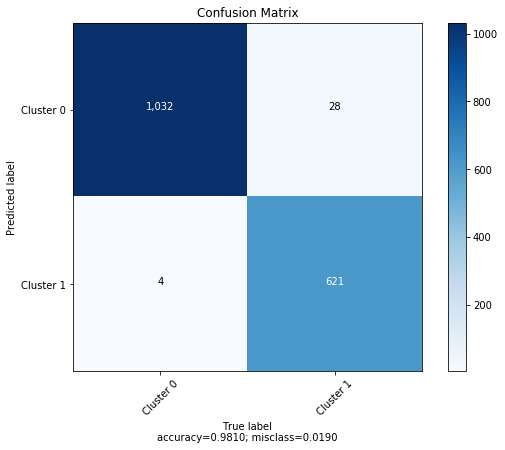

In [0]:
# Plot the confusion matrix of the cluster predictions
kmeans_predictions = lr.predict(X_test)
confusion = confusion_matrix(y_test, kmeans_predictions, labels=[0, 1])
plot_confusion_matrix(cm=confusion, target_names = ['Cluster 0', 'Cluster 1'], title = 'Confusion Matrix',normalize=False)

In general, we see that KMeans, as a clustering method, is relatively weak. With a silhoutte score of roughly .17, it implies that clusters aren't as dense as we would like. However, when it comes to predicting clusters, it appears that EmploymentStatus_Employed is a key variable in determining the cluster assignment and it performs rather well, with an accuracy of .98. Based on only the EmployementStatus_Employed variable, we notice that Cluster 0 more employed and better paid than Cluster 1. 

Hierarchical Clustering

In [0]:
# Run a hierarchical clustering model with complete linkage to find which 
# value of k is most efficient. 
efficiency_agg_complete = []

for i in range(2,16): 
  agg_cluster = AgglomerativeClustering(linkage='complete', affinity='cosine', n_clusters=i)
  y_pred_complete = agg_cluster.fit_predict(df)  
  efficiency_complete = metrics.silhouette_score(df, y_pred_complete, metric='manhattan')
  efficiency_agg_complete = np.append(efficiency_agg_complete, efficiency_complete)
  print("With {} clusters, the silhoutte score is {}".format(i, efficiency_complete))
  print("--------------------------------------------------------------------")

With 2 clusters, the silhoutte score is 0.13404795710711687
--------------------------------------------------------------------
With 3 clusters, the silhoutte score is 0.11297727883489016
--------------------------------------------------------------------
With 4 clusters, the silhoutte score is 0.0765303902445123
--------------------------------------------------------------------
With 5 clusters, the silhoutte score is 0.036704437548044394
--------------------------------------------------------------------
With 6 clusters, the silhoutte score is 0.047562770724064556
--------------------------------------------------------------------
With 7 clusters, the silhoutte score is 0.04670659937029953
--------------------------------------------------------------------
With 8 clusters, the silhoutte score is 0.035409227901016985
--------------------------------------------------------------------
With 9 clusters, the silhoutte score is 0.037880721661565434
----------------------------------

In [0]:
# Run a hierarchical clustering model with ward linkage to find which 
# value of k is most efficient. 
efficiency_agg_ward = []

for i in range(2,16): 
  agg_cluster = AgglomerativeClustering(linkage='ward', affinity='euclidean', n_clusters=i)
  y_pred_ward = agg_cluster.fit_predict(df)  
  efficiency_ward = metrics.silhouette_score(df, y_pred_ward, metric='manhattan')
  efficiency_agg_ward = np.append(efficiency_agg_ward, efficiency_ward)
  print("With {} clusters, the silhoutte score is {}".format(i, efficiency_ward))
  print("--------------------------------------------------------------------")

With 2 clusters, the silhoutte score is 0.1233689035250772
--------------------------------------------------------------------
With 3 clusters, the silhoutte score is 0.13839329267465197
--------------------------------------------------------------------
With 4 clusters, the silhoutte score is 0.1042582139643937
--------------------------------------------------------------------
With 5 clusters, the silhoutte score is 0.08895075008966812
--------------------------------------------------------------------
With 6 clusters, the silhoutte score is 0.07419065797602149
--------------------------------------------------------------------
With 7 clusters, the silhoutte score is 0.07421109503382334
--------------------------------------------------------------------
With 8 clusters, the silhoutte score is 0.07000698471422684
--------------------------------------------------------------------
With 9 clusters, the silhoutte score is 0.06523739984803185
---------------------------------------

In [0]:
# Run a hierarchical clustering model with average linkage to find which 
# value of k is most efficient. 
efficiency_agg_average = []

for i in range(2,16): 
  agg_cluster = AgglomerativeClustering(linkage='average', affinity='cosine', n_clusters=i)
  y_pred_average = agg_cluster.fit_predict(df)  
  efficiency_average = metrics.silhouette_score(df, y_pred_average, metric='manhattan')
  efficiency_agg_average = np.append(efficiency_agg_average, efficiency_average)
  print("With {} clusters, the silhoutte score is {}".format(i, efficiency_average))
  print("--------------------------------------------------------------------")

With 2 clusters, the silhoutte score is 0.1608866558519108
--------------------------------------------------------------------
With 3 clusters, the silhoutte score is 0.13540233788620235
--------------------------------------------------------------------
With 4 clusters, the silhoutte score is 0.0989353920667994
--------------------------------------------------------------------
With 5 clusters, the silhoutte score is 0.07708866902608505
--------------------------------------------------------------------
With 6 clusters, the silhoutte score is 0.05216465130275869
--------------------------------------------------------------------
With 7 clusters, the silhoutte score is 0.0359096031133561
--------------------------------------------------------------------
With 8 clusters, the silhoutte score is 0.029157290877532403
--------------------------------------------------------------------
With 9 clusters, the silhoutte score is 0.03859684475158021
---------------------------------------

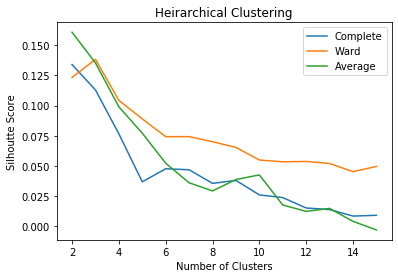

In [0]:
# Create a graph showing the relationship between Complete, Ward & Average 
# Heirarchical Clustering
plt.plot(range(2,16), efficiency_agg_complete, label = 'Complete')
plt.plot(range(2,16), efficiency_agg_ward, label = 'Ward')
plt.plot(range(2,16), efficiency_agg_average, label = 'Average')
plt.ylabel("Silhoutte Score")
plt.xlabel("Number of Clusters")
plt.title("Heirarchical Clustering")
plt.legend()
plt.show()

Again, it appears that k=2 has the highest silhoutte score across all models. At this value, the Average Method seems to perform best. We will use this method to determine the differences of variables between clusters. 

In [0]:
# Fit our Average model with k=2
agg_cluster = AgglomerativeClustering(linkage='average', affinity='cosine', n_clusters=2)
hierarchical_pred = agg_cluster.fit_predict(df) 
hierarchical = pd.DataFrame(hierarchical_pred)

# Add the predicted clusters to the dataframe
df_with_hierarchical = df.reset_index(drop=True)
df_with_hierarchical["Hierarchical Prediction"] = hierarchical
df_with_hierarchical

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,State_California,State_Nevada,State_Oregon,State_Washington,Response_Yes,Coverage_Extended,Coverage_Premium,Education_College,Education_Doctor,Education_High School or Below,Education_Master,EmploymentStatus_Employed,EmploymentStatus_Medical Leave,EmploymentStatus_Retired,EmploymentStatus_Unemployed,Gender_M,Location Code_Suburban,Location Code_Urban,Marital Status_Married,Marital Status_Single,Policy Type_Personal Auto,Policy_Corporate L2,Policy_Corporate L3,Policy_Personal L1,Policy_Personal L2,Policy_Personal L3,Renew Offer Type_Offer2,Renew Offer Type_Offer3,Renew Offer Type_Offer4,Sales Channel_Branch,Sales Channel_Call Center,Sales Channel_Web,Vehicle Class_SUV,Vehicle Class_Sports Car,Vehicle Class_Two-Door Car,Vehicle Size_Medsize,Vehicle Size_Small,Hierarchical Prediction
0,-0.759622,0.614267,-0.789845,1.280937,-1.215992,-0.421723,-0.823148,-0.091738,-0.728885,-0.326875,-0.627254,-0.310139,-0.408814,-0.651768,-0.311747,-0.644933,-0.199382,-0.631299,-0.297786,0.778870,-0.22447,-0.179891,-0.583474,-0.977224,0.769064,-0.459647,0.848841,-0.604146,-1.855258,-0.268923,-0.363513,-0.40465,-0.567935,-0.800073,-0.689546,-0.431118,-0.353601,-0.625050,-0.493609,-0.408814,-0.506966,-0.240087,1.906597,0.646409,-0.485409,0
1,-0.101634,-1.236907,0.223567,-0.208604,-0.215041,-0.421723,1.264593,0.903294,-0.728885,-0.326875,-0.627254,-0.310139,-0.408814,1.534289,-0.311747,-0.644933,-0.199382,-0.631299,-0.297786,-1.283911,-0.22447,-0.179891,1.713871,-0.977224,0.769064,-0.459647,-1.178077,1.655230,0.539009,-0.268923,-0.363513,-0.40465,-0.567935,1.249886,-0.689546,2.319548,-0.353601,-0.625050,-0.493609,-0.408814,-0.506966,-0.240087,-0.524495,0.646409,-0.485409,1
2,0.610709,0.367319,0.791077,0.287910,-0.358034,-0.421723,-0.405600,0.656470,-0.728885,-0.326875,-0.627254,-0.310139,-0.408814,-0.651768,-0.311747,-0.644933,-0.199382,-0.631299,-0.297786,0.778870,-0.22447,-0.179891,-0.583474,-0.977224,0.769064,-0.459647,0.848841,-0.604146,0.539009,-0.268923,-0.363513,-0.40465,-0.567935,1.249886,-0.689546,-0.431118,-0.353601,-0.625050,-0.493609,-0.408814,-0.506966,-0.240087,1.906597,0.646409,-0.485409,0
3,0.004864,-1.236907,0.710004,0.287910,0.607168,-0.421723,1.264593,0.505763,1.371959,-0.326875,-0.627254,-0.310139,-0.408814,-0.651768,-0.311747,-0.644933,-0.199382,-0.631299,-0.297786,-1.283911,-0.22447,-0.179891,1.713871,1.023306,0.769064,-0.459647,0.848841,-0.604146,-1.855258,-0.268923,-0.363513,-0.40465,-0.567935,-0.800073,-0.689546,-0.431118,-0.353601,-0.625050,2.025893,-0.408814,1.972517,-0.240087,-0.524495,0.646409,-0.485409,1
4,-0.759622,0.205110,-0.627699,-0.307907,-0.143545,-0.421723,-0.823148,-1.052468,-0.728885,-0.326875,-0.627254,-0.310139,-0.408814,-0.651768,-0.311747,-0.644933,-0.199382,-0.631299,-0.297786,0.778870,-0.22447,-0.179891,-0.583474,1.023306,-1.300283,-0.459647,-1.178077,1.655230,0.539009,-0.268923,-0.363513,-0.40465,-0.567935,-0.800073,-0.689546,-0.431118,-0.353601,-0.625050,-0.493609,-0.408814,-0.506966,-0.240087,-0.524495,0.646409,-0.485409,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8417,0.610709,1.129645,-0.627699,0.287910,1.214888,-0.421723,-0.405600,-0.860191,1.371959,-0.326875,-0.627254,-0.310139,-0.408814,-0.651768,-0.311747,-0.644933,-0.199382,-0.631299,-0.297786,0.778870,-0.22447,-0.179891,-0.583474,1.023306,-1.300283,2.175581,0.848841,-0.604146,0.539009,-0.268923,-0.363513,-0.40465,-0.567935,-0.800073,1.450231,-0.431118,-0.353601,-0.625050,-0.493609,-0.408814,-0.506966,-0.240087,-0.524495,0.646409,-0.485409,0
8418,-0.722256,-0.526228,-0.384480,-0.109301,-0.715516,-0.421723,-0.823148,-0.114849,1.371959,-0.326875,-0.627254,-0.310139,-0.408814,1.534289,-0.311747,1.550549,-0.199382,-0.631299,-0.297786,0.77

In [0]:
# Describe the data in the cluster labeled 1
df_with_hierarchical[df_with_hierarchical['Hierarchical Prediction']==1].describe()

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,State_California,State_Nevada,State_Oregon,State_Washington,Response_Yes,Coverage_Extended,Coverage_Premium,Education_College,Education_Doctor,Education_High School or Below,Education_Master,EmploymentStatus_Employed,EmploymentStatus_Medical Leave,EmploymentStatus_Retired,EmploymentStatus_Unemployed,Gender_M,Location Code_Suburban,Location Code_Urban,Marital Status_Married,Marital Status_Single,Policy Type_Personal Auto,Policy_Corporate L2,Policy_Corporate L3,Policy_Personal L1,Policy_Personal L2,Policy_Personal L3,Renew Offer Type_Offer2,Renew Offer Type_Offer3,Renew Offer Type_Offer4,Sales Channel_Branch,Sales Channel_Call Center,Sales Channel_Web,Vehicle Class_SUV,Vehicle Class_Sports Car,Vehicle Class_Two-Door Car,Vehicle Size_Medsize,Vehicle Size_Small,Hierarchical Prediction
count,2345.000000,2345.000000,2345.000000,2345.000000,2345.000000,2345.000000,2345.000000,2345.000000,2345.000000,2.345000e+03,2345.000000,2.345000e+03,2.345000e+03,2345.000000,2.345000e+03,2345.000000,2.345000e+03,2345.000000,2.345000e+03,2345.000000,2.345000e+03,2.345000e+03,2345.000000,2345.000000,2345.000000,2345.000000,2345.000000,2345.000000,2345.000000,2.345000e+03,2.345000e+03,2.345000e+03,2345.000000,2345.000000,2345.000000,2345.000000,2.345000e+03,2345.000000,2345.000000,2.345000e+03,2345.000000,2.345000e+03,2345.000000,2345.000000,2345.000000,2345.0
mean,-0.212258,-1.093309,-0.023213,-0.015419,0.001491,-0.199925,-0.126760,0.371889,0.004843,-3.268748e-01,-0.008644,-3.101393e-01,-4.088137e-01,0.012905,-3.117467e-01,-0.008290,-1.993818e-01,0.116907,-2.977857e-01,-1.181872,-2.244697e-01,-1.798913e-01,1.338654,0.052473,0.679936,-0.457400,-0.574755,0.743772,0.015231,-2.689235e-01,-3.635126e-01,-4.046503e-01,-0.004876,0.006798,-0.191329,-0.002976,-3.536006e-01,0.005899,-0.034834,-4.088137e-01,0.127443,-2.400866e-01,-0.042423,0.020654,-0.044691,1.0
std,0.473479,0.385614,0.798151,0.887553,0.876621,0.441340,0.756109,0.546494,1.001758,8.439495e-15,0.995987,1.665690e-14,1.215954e-14,1.005810,9.549954e-15,0.996417,7.773219e-15,1.047942,1.088251e-14,0.447391,1.610167e-15,5.829914e-15,0.849425,1.000046,0.420199,0.076943,0.926959,1.108645,0.990019,8.994725e-15,2.226472e-14,9.383385e-15,0.997288,1.001718,0.904545,0.997394,6.440667e-15,1.003068,0.972530,1.215954e-14,1.082142,6.301859e-15,0.969519,0.990652,0.963340,0.0
min,-0.759622,-1.236907,-0.951991,-1.201632,-1.215992,-0.421723,-0.823148,-1.052468,-0.728885,-3.268748e-01,-0.627254,-3.101393e-01,-4.088137e-01,-0.651768,-3.117467e-01,-0.644933,-1.993818e-01,-0.631299,-2.977857e-01,-1.283911,-2.244697e-01,-1.798913e-01,-0.583474,-0.977224,-1.300283,-0.459647,-1.178077,-0.604146,-1.855258,-2.689235e-01,-3.635126e-01,-4.046503e-01,-0.567935,-0.800073,-0.689546,-0.431118,-3.536006e-01,-0.625050,-0.493609,-4.088137e-01,-0.506966,-2.400866e-01,-0.524495,-1.547007,-0.485409,1.0
25%,-0.606682,-1.236907,-0.789845,-0.903723,-0.822761,-0.421723,-0.823148,-0.055352,-0.728885,-3.268748e-01,-0.627254,-3.101393e-01,-4.088137e-01,-0.651768,-3.117467e-01,-0.644933,-1.993818e-01,-0.631299,-2.977857e-01,-1.283911,-2.244697e-01,-1.798913e-01,1.713871,-0.977224,0.769064,-0.459647,-1.178077,-0.604146,0.539009,-2.689235e-01,-3.635126e-01,-4.046503e-01,-0.567935,-0.800073,-0.689546,-0.431118,-3.536006e-01,-0.625050,-0.493609,-4.088137e-01,-0.506966,-2.400866e-01,-0.524495,-1.547007,-0.485409,1.0
50%,-0.369348,-1.236907,-0.181798,-0.009999,-0.000552,-0.421723,-0.405600,0.478244,-0.728885,-3.268748e-01,-0.627254,-3.101393e-01,-4.088137e-01,-0.651768,-3.117467e-01,-0.644933,-1.993818e-01,-0.631299,-2.977857e-01,-1.283911,-2.244697e-01,-1.798913e-01,1.713871,1.023306,0.769064,-0.459647,-1.178077,1.655230,0.539009,-2.689235e-01,-3.635126e-01,-4.046503e-01,-0.567935,-0.800073,-0.689546,-0.431118,-3.536006e-01,-0.625050,-0.493609,-4.088137e-01,-0.506966,-2.400866e-01,-

In [0]:
# Describe the data in the cluster labeled 0
df_with_hierarchical[df_with_hierarchical['Hierarchical Prediction']==0].describe()

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,State_California,State_Nevada,State_Oregon,State_Washington,Response_Yes,Coverage_Extended,Coverage_Premium,Education_College,Education_Doctor,Education_High School or Below,Education_Master,EmploymentStatus_Employed,EmploymentStatus_Medical Leave,EmploymentStatus_Retired,EmploymentStatus_Unemployed,Gender_M,Location Code_Suburban,Location Code_Urban,Marital Status_Married,Marital Status_Single,Policy Type_Personal Auto,Policy_Corporate L2,Policy_Corporate L3,Policy_Personal L1,Policy_Personal L2,Policy_Personal L3,Renew Offer Type_Offer2,Renew Offer Type_Offer3,Renew Offer Type_Offer4,Sales Channel_Branch,Sales Channel_Call Center,Sales Channel_Web,Vehicle Class_SUV,Vehicle Class_Sports Car,Vehicle Class_Two-Door Car,Vehicle Size_Medsize,Vehicle Size_Small,Hierarchical Prediction
count,6077.000000,6077.000000,6077.000000,6077.000000,6077.000000,6077.000000,6077.000000,6077.000000,6077.000000,6.077000e+03,6077.000000,6.077000e+03,6.077000e+03,6077.000000,6.077000e+03,6077.000000,6.077000e+03,6077.000000,6.077000e+03,6077.000000,6.077000e+03,6.077000e+03,6077.000000,6077.000000,6077.000000,6077.000000,6077.000000,6077.000000,6077.000000,6.077000e+03,6.077000e+03,6.077000e+03,6077.000000,6077.000000,6077.000000,6077.000000,6.077000e+03,6077.000000,6077.000000,6.077000e+03,6077.000000,6.077000e+03,6077.000000,6077.000000,6077.000000,6077.0
mean,-0.175234,0.340503,-0.111511,-0.033709,-0.009723,-0.194092,-0.108087,-0.248696,-0.001869,-3.268748e-01,0.003335,-3.101393e-01,-4.088137e-01,-0.004980,-3.117467e-01,0.003199,-1.993818e-01,-0.045112,-2.977857e-01,0.456062,-2.244697e-01,-1.798913e-01,-0.516561,-0.020248,-0.262375,0.176502,0.221787,-0.287008,-0.005877,-2.689235e-01,-3.635126e-01,-4.046503e-01,0.001882,-0.002623,0.073830,0.001149,-3.536006e-01,-0.002276,0.013442,-4.088137e-01,-0.049178,-2.400866e-01,0.016370,-0.007970,0.017245,0.0
std,0.474910,0.713092,0.770678,0.889953,0.878254,0.445559,0.772235,0.635323,0.999479,2.476001e-14,1.001688,4.124818e-14,1.665472e-16,0.997870,1.421202e-14,1.001525,2.281696e-14,0.977314,1.598853e-14,0.749513,1.665472e-15,2.228956e-14,0.386354,0.999410,1.034753,1.127795,0.936982,0.784894,1.003926,3.730656e-14,1.221346e-15,4.663320e-15,1.001202,0.999489,1.025126,1.001166,3.886100e-15,0.998970,1.010240,1.665472e-16,0.962113,2.154010e-14,1.011200,1.003633,1.013424,0.0
min,-0.759622,-1.236907,-0.951991,-1.201632,-1.215992,-0.421723,-0.823148,-1.052468,-0.728885,-3.268748e-01,-0.627254,-3.101393e-01,-4.088137e-01,-0.651768,-3.117467e-01,-0.644933,-1.993818e-01,-0.631299,-2.977857e-01,-1.283911,-2.244697e-01,-1.798913e-01,-0.583474,-0.977224,-1.300283,-0.459647,-1.178077,-0.604146,-1.855258,-2.689235e-01,-3.635126e-01,-4.046503e-01,-0.567935,-0.800073,-0.689546,-0.431118,-3.536006e-01,-0.625050,-0.493609,-4.088137e-01,-0.506966,-2.400866e-01,-0.524495,-1.547007,-0.485409,0.0
25%,-0.590740,-0.289313,-0.830381,-0.903723,-0.858509,-0.421723,-0.823148,-0.860075,-0.728885,-3.268748e-01,-0.627254,-3.101393e-01,-4.088137e-01,-0.651768,-3.117467e-01,-0.644933,-1.993818e-01,-0.631299,-2.977857e-01,0.778870,-2.244697e-01,-1.798913e-01,-0.583474,-0.977224,-1.300283,-0.459647,-1.178077,-0.604146,0.539009,-2.689235e-01,-3.635126e-01,-4.046503e-01,-0.567935,-0.800073,-0.689546,-0.431118,-3.536006e-01,-0.625050,-0.493609,-4.088137e-01,-0.506966,-2.400866e-01,-0.524495,-1.547007,-0.485409,0.0
50%,-0.309744,0.370872,-0.384480,-0.109301,-0.000552,-0.421723,-0.405600,-0.312547,-0.728885,-3.268748e-01,-0.627254,-3.101393e-01,-4.088137e-01,-0.651768,-3.117467e-01,-0.644933,-1.993818e-01,-0.631299,-2.977857e-01,0.778870,-2.244697e-01,-1.798913e-01,-0.583474,-0.977224,0.769064,-0.459647,0.848841,-0.604146,0.539009,-2.689235e-01,-3.635126e-01,-4.046503e-01,-0.567935,-0.800073,-0.689546,-0.431118,-3.536006e-01,-0.625050,-0.493609,-4.088137e-01,-0.506966,-2.400866e-

Again, income, total claim amount, employment status and the previously mentioned variables are have the largest difference between both groups. In this model, we see that Cluster 0 is the better off cluster (with higher income and more employment) than Cluster 1. As done before, we will run two regressions. One will contain the 5 variables with the largest differences between groups and the other will contain exclusively the EmploymentStatus_Employed variable. 

In [0]:
# Declare the 5 variables with the larges differences between both clusters
important_vars = ['Income', 'Total Claim Amount','Marital Status_Married','Location Code_Suburban', 'Vehicle Class_SUV']

# Run an OLS regression to see how much each variable influenced cluster assignment
X_hier1 = sm.add_constant(df[important_vars])
results_hier1 = sm.OLS(hierarchical_pred, X_hier1).fit()
print(results_hier1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     2083.
Date:                Wed, 05 Feb 2020   Prob (F-statistic):               0.00
Time:                        21:21:48   Log-Likelihood:                -1800.7
No. Observations:                8422   AIC:                             3613.
Df Residuals:                    8416   BIC:                             3656.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [0]:
# As an alternate method, I will run the second regression exclusively on the 
# EmploymentStatus_Employed variable.
X_hier2 = sm.add_constant(df['EmploymentStatus_Employed'])
results_hier2 = sm.OLS(hierarchical_pred, X_hier2).fit()
print(results_hier2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     9845.
Date:                Wed, 05 Feb 2020   Prob (F-statistic):               0.00
Time:                        21:21:27   Log-Likelihood:                -1931.2
No. Observations:                8422   AIC:                             3866.
Df Residuals:                    8420   BIC:                             3880.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Between these two regressions, it appears that the first regression, which contains more variables, has a slightly higer Adjusted R value. Therefore, we will use that model to determine how successful hierarchical cluster is at predicting an observation's cluster. 

In [0]:
# Split the data set into testing & training sets
X_hier1 = sm.add_constant(df[important_vars])
X_train, X_test, y_train, y_test = train_test_split(X_hier1, df_with_hierarchical['Hierarchical Prediction'], test_size=.2)

# Check to see how accurate the cluster prediction was
lr = LogisticRegression(solver='lbfgs', penalty='l2')
lr.fit(X_train, y_train)
print("The Hierarchical prediction was correct {} of the time".format(lr.score(X_test, y_test)))

The Hierarchical prediction was correct 0.9412462908011869 of the time


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


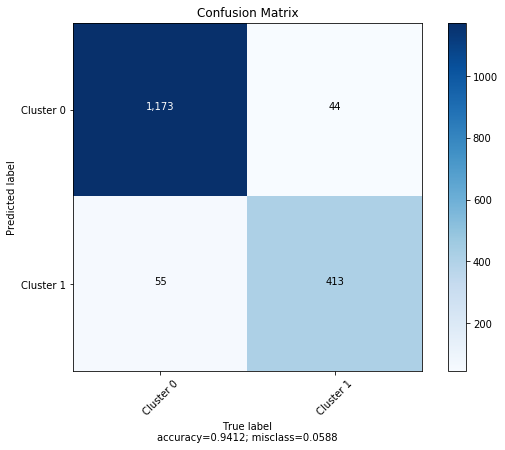

In [0]:
# Plot the confusion matrix of the cluster predictions
hierarchical_predictions = lr.predict(X_test)
confusion = confusion_matrix(y_test, hierarchical_predictions, labels=[0, 1])
plot_confusion_matrix(cm=confusion, target_names = ['Cluster 0', 'Cluster 1'], title = 'Confusion Matrix',normalize=False)

Between this example and the K-Means example, the KMeans example was better accurate at predicting the cluster assignment of each observation, since this model is only accurate with a value of .94. Additionally, this model has a lower significantly lower Adjusted R value than the KMeans model. Lets try the same process with DBSCAN too see if it performs any better than Hierarchical Clustering. 

DBSCAN

In [0]:
# Try to perform clustering with DBSCAN

efficiency_dbscan = []

for i in range(0,1000, 50): 
  dbscan_cluster = DBSCAN(eps=5, min_samples=i)
  clusters = dbscan_cluster.fit_predict(df_corr)
  if clusters.any() >= 2:
    efficiency = metrics.silhouette_score(df, clusters, metric='manhattan')
    efficiency_dbscan = np.append(efficiency_dbscan, efficiency)
    print("With {} neighbors, the silhoutte score is {}".format(i, efficiency))
    print("--------------------------------------------------------------------")
  else: 
    print("Not enough clusters!")

I've tried multiple approaches and changes the microparameters multiple timees; however, I cannot get DBSCAN to print more than 1 cluster. I will leave this custering method out of my project and continue on by experimenting with Gaussian Mixture Model. 

Gaussian Mixture Model

In [0]:
efficiency_gmm = []

for i in range(2,11): 
  gmm_cluster = GaussianMixture(n_components=i)
  clusters = gmm_cluster.fit_predict(df) 
  efficiency_for_gmm = metrics.silhouette_score(df, clusters, metric='manhattan')
  efficiency_gmm = np.append(efficiency_gmm, efficiency_for_gmm)
  print("With {} clusters, the silhoutte score is {}".format(i, efficiency_for_gmm))
  print("--------------------------------------------------------------------")

With 2 clusters, the silhoutte score is 0.1694369509202146
--------------------------------------------------------------------
With 3 clusters, the silhoutte score is 0.13388196275467407
--------------------------------------------------------------------
With 4 clusters, the silhoutte score is 0.1194867413491965
--------------------------------------------------------------------
With 5 clusters, the silhoutte score is 0.09512024741796332
--------------------------------------------------------------------
With 6 clusters, the silhoutte score is 0.10947464917287163
--------------------------------------------------------------------
With 7 clusters, the silhoutte score is 0.10878970552014651
--------------------------------------------------------------------
With 8 clusters, the silhoutte score is 0.09414840876940395
--------------------------------------------------------------------
With 9 clusters, the silhoutte score is 0.07690840024063066
---------------------------------------

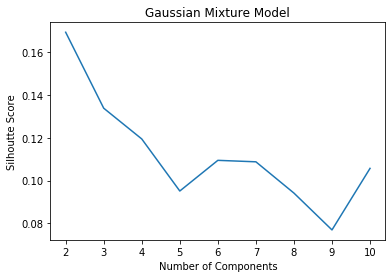

In [0]:
# Create a graph showing the relationship between N Components & Silhoutte Score
plt.plot(range(2,11), efficiency_gmm)
plt.ylabel("Silhoutte Score")
plt.xlabel("Number of Components")
plt.title("Gaussian Mixture Model")
plt.show()

It appears that the Gaussian Mixture Model performs best with N n=2 components, which is consistent with each of our previous models. Again, the silhoutte score is relatively low and around .17, which indicates realively sparce clusters. As done in the previous models, I will run two classifications to see which variables have the most explicative power in this model. 

In [0]:
# Fit our Average model with n=2
gmm_cluster = GaussianMixture(n_components=2)
gmm_pred = gmm_cluster.fit_predict(df) 
gaussian_mix = pd.DataFrame(gmm_pred)

# Add the predicted clusters to the dataframe
df_with_gmm = df.reset_index(drop=True)
df_with_gmm["GMM Prediction"] = gaussian_mix
df_with_gmm

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,State_California,State_Nevada,State_Oregon,State_Washington,Response_Yes,Coverage_Extended,Coverage_Premium,Education_College,Education_Doctor,Education_High School or Below,Education_Master,EmploymentStatus_Employed,EmploymentStatus_Medical Leave,EmploymentStatus_Retired,EmploymentStatus_Unemployed,Gender_M,Location Code_Suburban,Location Code_Urban,Marital Status_Married,Marital Status_Single,Policy Type_Personal Auto,Policy_Corporate L2,Policy_Corporate L3,Policy_Personal L1,Policy_Personal L2,Policy_Personal L3,Renew Offer Type_Offer2,Renew Offer Type_Offer3,Renew Offer Type_Offer4,Sales Channel_Branch,Sales Channel_Call Center,Sales Channel_Web,Vehicle Class_SUV,Vehicle Class_Sports Car,Vehicle Class_Two-Door Car,Vehicle Size_Medsize,Vehicle Size_Small,GMM Prediction
0,-0.759622,0.614267,-0.789845,1.280937,-1.215992,-0.421723,-0.823148,-0.091738,-0.728885,-0.326875,-0.627254,-0.310139,-0.408814,-0.651768,-0.311747,-0.644933,-0.199382,-0.631299,-0.297786,0.778870,-0.22447,-0.179891,-0.583474,-0.977224,0.769064,-0.459647,0.848841,-0.604146,-1.855258,-0.268923,-0.363513,-0.40465,-0.567935,-0.800073,-0.689546,-0.431118,-0.353601,-0.625050,-0.493609,-0.408814,-0.506966,-0.240087,1.906597,0.646409,-0.485409,1
1,-0.101634,-1.236907,0.223567,-0.208604,-0.215041,-0.421723,1.264593,0.903294,-0.728885,-0.326875,-0.627254,-0.310139,-0.408814,1.534289,-0.311747,-0.644933,-0.199382,-0.631299,-0.297786,-1.283911,-0.22447,-0.179891,1.713871,-0.977224,0.769064,-0.459647,-1.178077,1.655230,0.539009,-0.268923,-0.363513,-0.40465,-0.567935,1.249886,-0.689546,2.319548,-0.353601,-0.625050,-0.493609,-0.408814,-0.506966,-0.240087,-0.524495,0.646409,-0.485409,0
2,0.610709,0.367319,0.791077,0.287910,-0.358034,-0.421723,-0.405600,0.656470,-0.728885,-0.326875,-0.627254,-0.310139,-0.408814,-0.651768,-0.311747,-0.644933,-0.199382,-0.631299,-0.297786,0.778870,-0.22447,-0.179891,-0.583474,-0.977224,0.769064,-0.459647,0.848841,-0.604146,0.539009,-0.268923,-0.363513,-0.40465,-0.567935,1.249886,-0.689546,-0.431118,-0.353601,-0.625050,-0.493609,-0.408814,-0.506966,-0.240087,1.906597,0.646409,-0.485409,1
3,0.004864,-1.236907,0.710004,0.287910,0.607168,-0.421723,1.264593,0.505763,1.371959,-0.326875,-0.627254,-0.310139,-0.408814,-0.651768,-0.311747,-0.644933,-0.199382,-0.631299,-0.297786,-1.283911,-0.22447,-0.179891,1.713871,1.023306,0.769064,-0.459647,0.848841,-0.604146,-1.855258,-0.268923,-0.363513,-0.40465,-0.567935,-0.800073,-0.689546,-0.431118,-0.353601,-0.625050,2.025893,-0.408814,1.972517,-0.240087,-0.524495,0.646409,-0.485409,0
4,-0.759622,0.205110,-0.627699,-0.307907,-0.143545,-0.421723,-0.823148,-1.052468,-0.728885,-0.326875,-0.627254,-0.310139,-0.408814,-0.651768,-0.311747,-0.644933,-0.199382,-0.631299,-0.297786,0.778870,-0.22447,-0.179891,-0.583474,1.023306,-1.300283,-0.459647,-1.178077,1.655230,0.539009,-0.268923,-0.363513,-0.40465,-0.567935,-0.800073,-0.689546,-0.431118,-0.353601,-0.625050,-0.493609,-0.408814,-0.506966,-0.240087,-0.524495,0.646409,-0.485409,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8417,0.610709,1.129645,-0.627699,0.287910,1.214888,-0.421723,-0.405600,-0.860191,1.371959,-0.326875,-0.627254,-0.310139,-0.408814,-0.651768,-0.311747,-0.644933,-0.199382,-0.631299,-0.297786,0.778870,-0.22447,-0.179891,-0.583474,1.023306,-1.300283,2.175581,0.848841,-0.604146,0.539009,-0.268923,-0.363513,-0.40465,-0.567935,-0.800073,1.450231,-0.431118,-0.353601,-0.625050,-0.493609,-0.408814,-0.506966,-0.240087,-0.524495,0.646409,-0.485409,1
8418,-0.722256,-0.526228,-0.384480,-0.109301,-0.715516,-0.421723,-0.823148,-0.114849,1.371959,-0.326875,-0.627254,-0.310139,-0.408814,1.534289,-0.311747,1.550549,-0.199382,-0.631299,-0.297786,0.778870,-0.2

In [0]:
# Describe the data in the cluster labeled 1
df_with_gmm[df_with_gmm['GMM Prediction']==1].describe()

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,State_California,State_Nevada,State_Oregon,State_Washington,Response_Yes,Coverage_Extended,Coverage_Premium,Education_College,Education_Doctor,Education_High School or Below,Education_Master,EmploymentStatus_Employed,EmploymentStatus_Medical Leave,EmploymentStatus_Retired,EmploymentStatus_Unemployed,Gender_M,Location Code_Suburban,Location Code_Urban,Marital Status_Married,Marital Status_Single,Policy Type_Personal Auto,Policy_Corporate L2,Policy_Corporate L3,Policy_Personal L1,Policy_Personal L2,Policy_Personal L3,Renew Offer Type_Offer2,Renew Offer Type_Offer3,Renew Offer Type_Offer4,Sales Channel_Branch,Sales Channel_Call Center,Sales Channel_Web,Vehicle Class_SUV,Vehicle Class_Sports Car,Vehicle Class_Two-Door Car,Vehicle Size_Medsize,Vehicle Size_Small,GMM Prediction
count,5242.000000,5242.000000,5242.000000,5242.000000,5242.000000,5242.000000,5242.000000,5242.000000,5242.000000,5.242000e+03,5242.000000,5.242000e+03,5.242000e+03,5242.000000,5.242000e+03,5242.000000,5.242000e+03,5242.000000,5.242000e+03,5.242000e+03,5.242000e+03,5.242000e+03,5.242000e+03,5242.000000,5242.000000,5242.000000,5242.000000,5242.000000,5242.000000,5.242000e+03,5.242000e+03,5.242000e+03,5242.000000,5242.000000,5242.000000,5242.000000,5.242000e+03,5242.000000,5242.000000,5.242000e+03,5242.000000,5.242000e+03,5242.000000,5242.000000,5242.000000,5242.0
mean,-0.167299,0.523441,-0.095490,-0.032864,-0.015569,-0.190976,-0.109843,-0.278772,-0.004290,-3.268748e-01,-0.000046,-3.101393e-01,-4.088137e-01,-0.008712,-3.117467e-01,-0.003292,-1.993818e-01,-0.040910,-2.977857e-01,7.788701e-01,-2.244697e-01,-1.798913e-01,-5.834745e-01,-0.008253,-0.336667,0.197903,0.199237,-0.235198,-0.004520,-2.689235e-01,-3.635126e-01,-4.046503e-01,-0.010860,0.003564,0.107666,0.024877,-3.536006e-01,0.006944,0.012983,-4.088137e-01,-0.019773,-2.400866e-01,0.015336,0.018344,-0.006605,1.0
std,0.474343,0.596735,0.776474,0.890249,0.880576,0.447802,0.772113,0.641632,0.998706,1.759871e-14,1.000073,3.875048e-14,2.370552e-14,0.996205,1.371256e-14,0.998598,1.920869e-14,0.979558,1.548909e-14,3.475330e-14,1.637735e-15,1.826491e-14,3.930564e-14,0.999871,1.032329,1.140470,0.945980,0.835226,1.003056,3.447571e-14,1.149190e-14,2.870200e-14,0.993537,1.000890,1.034656,1.023015,6.717490e-15,1.003451,1.009910,2.370552e-14,0.985300,9.437796e-15,1.010522,0.991630,0.994859,0.0
min,-0.759622,-0.578696,-0.951991,-1.201632,-1.215992,-0.421723,-0.823148,-1.052468,-0.728885,-3.268748e-01,-0.627254,-3.101393e-01,-4.088137e-01,-0.651768,-3.117467e-01,-0.644933,-1.993818e-01,-0.631299,-2.977857e-01,7.788701e-01,-2.244697e-01,-1.798913e-01,-5.834745e-01,-0.977224,-1.300283,-0.459647,-1.178077,-0.604146,-1.855258,-2.689235e-01,-3.635126e-01,-4.046503e-01,-0.567935,-0.800073,-0.689546,-0.431118,-3.536006e-01,-0.625050,-0.493609,-4.088137e-01,-0.506966,-2.400866e-01,-0.524495,-1.547007,-0.485409,1.0
25%,-0.573891,-0.016056,-0.830381,-0.903723,-0.894258,-0.421723,-0.823148,-0.946597,-0.728885,-3.268748e-01,-0.627254,-3.101393e-01,-4.088137e-01,-0.651768,-3.117467e-01,-0.644933,-1.993818e-01,-0.631299,-2.977857e-01,7.788701e-01,-2.244697e-01,-1.798913e-01,-5.834745e-01,-0.977224,-1.300283,-0.459647,-1.178077,-0.604146,0.539009,-2.689235e-01,-3.635126e-01,-4.046503e-01,-0.567935,-0.800073,-0.689546,-0.431118,-3.536006e-01,-0.625050,-0.493609,-4.088137e-01,-0.506966,-2.400866e-01,-0.524495,-1.547007,-0.485409,1.0
50%,-0.303035,0.587359,-0.343944,-0.109301,-0.036300,-0.421723,-0.405600,-0.352086,-0.728885,-3.268748e-01,-0.627254,-3.101393e-01,-4.088137e-01,-0.651768,-3.117467e-01,-0.644933,-1.993818e-01,-0.631299,-2.977857e-01,7.788701e-01,-2.244697e-01,-1.798913e-01,-5.834745e-01,-0.977224,-1.300283,-0.459647,0.848841,-0.604146,0.539009,-2.689235e-01,-3.635126e-01,-4.046503e-01,-0.567935,-0.800073,-0.689546,-0.431118,-3.536006e-01,-0.625050,-0.493609,-

In [0]:
# Describe the data in the cluster labeled 0
df_with_gmm[df_with_gmm['GMM Prediction']==0].describe()

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,State_California,State_Nevada,State_Oregon,State_Washington,Response_Yes,Coverage_Extended,Coverage_Premium,Education_College,Education_Doctor,Education_High School or Below,Education_Master,EmploymentStatus_Employed,EmploymentStatus_Medical Leave,EmploymentStatus_Retired,EmploymentStatus_Unemployed,Gender_M,Location Code_Suburban,Location Code_Urban,Marital Status_Married,Marital Status_Single,Policy Type_Personal Auto,Policy_Corporate L2,Policy_Corporate L3,Policy_Personal L1,Policy_Personal L2,Policy_Personal L3,Renew Offer Type_Offer2,Renew Offer Type_Offer3,Renew Offer Type_Offer4,Sales Channel_Branch,Sales Channel_Call Center,Sales Channel_Web,Vehicle Class_SUV,Vehicle Class_Sports Car,Vehicle Class_Two-Door Car,Vehicle Size_Medsize,Vehicle Size_Small,GMM Prediction
count,3180.000000,3180.000000,3180.000000,3180.000000,3180.000000,3180.000000,3180.000000,3180.000000,3180.000000,3.180000e+03,3180.000000,3.180000e+03,3.180000e+03,3180.000000,3.180000e+03,3180.000000,3.180000e+03,3180.000000,3.180000e+03,3.180000e+03,3.180000e+03,3.180000e+03,3180.000000,3180.000000,3180.000000,3180.000000,3180.000000,3180.000000,3180.000000,3.180000e+03,3.180000e+03,3.180000e+03,3180.000000,3180.000000,3180.000000,3180.000000,3.180000e+03,3180.000000,3180.000000,3.180000e+03,3180.000000,3.180000e+03,3180.000000,3180.000000,3180.000000,3180.0
mean,-0.215616,-1.018380,-0.072808,-0.021615,0.008183,-0.203529,-0.118962,0.258514,0.007071,-3.268748e-01,0.000076,-3.101393e-01,-4.088137e-01,0.014361,-3.117467e-01,0.005427,-1.993818e-01,0.067437,-2.977857e-01,-1.283911e+00,-2.244697e-01,-1.798913e-01,0.961815,0.013605,0.554971,-0.326229,-0.328429,0.387706,0.007451,-2.689235e-01,-3.635126e-01,-4.046503e-01,0.017901,-0.005875,-0.177480,-0.041008,-3.536006e-01,-0.011447,-0.021401,-4.088137e-01,0.032594,-2.400866e-01,-0.025280,-0.030239,0.010889,0.0
std,0.474028,0.329578,0.784073,0.887751,0.873041,0.438612,0.760670,0.581553,1.002404,1.610077e-14,1.000194,2.720474e-14,5.607508e-15,1.006373,1.154814e-14,1.002597,2.220795e-15,1.029580,1.304717e-14,3.242361e-14,1.610077e-15,7.495184e-16,1.078197,1.000378,0.630334,0.577835,1.000290,1.121424,0.995213,2.115307e-14,1.821052e-14,7.717264e-15,1.010621,0.998818,0.913103,0.959774,6.551346e-15,0.994496,0.983389,5.607508e-15,1.023247,8.910941e-15,0.982204,1.013233,1.008636,0.0
min,-0.759622,-1.236907,-0.951991,-1.201632,-1.215992,-0.421723,-0.823148,-1.052468,-0.728885,-3.268748e-01,-0.627254,-3.101393e-01,-4.088137e-01,-0.651768,-3.117467e-01,-0.644933,-1.993818e-01,-0.631299,-2.977857e-01,-1.283911e+00,-2.244697e-01,-1.798913e-01,-0.583474,-0.977224,-1.300283,-0.459647,-1.178077,-0.604146,-1.855258,-2.689235e-01,-3.635126e-01,-4.046503e-01,-0.567935,-0.800073,-0.689546,-0.431118,-3.536006e-01,-0.625050,-0.493609,-4.088137e-01,-0.506966,-2.400866e-01,-0.524495,-1.547007,-0.485409,0.0
25%,-0.624454,-1.236907,-0.830381,-0.903723,-0.822761,-0.421723,-0.823148,-0.253238,-0.728885,-3.268748e-01,-0.627254,-3.101393e-01,-4.088137e-01,-0.651768,-3.117467e-01,-0.644933,-1.993818e-01,-0.631299,-2.977857e-01,-1.283911e+00,-2.244697e-01,-1.798913e-01,-0.583474,-0.977224,0.769064,-0.459647,-1.178077,-0.604146,0.539009,-2.689235e-01,-3.635126e-01,-4.046503e-01,-0.567935,-0.800073,-0.689546,-0.431118,-3.536006e-01,-0.625050,-0.493609,-4.088137e-01,-0.506966,-2.400866e-01,-0.524495,-1.547007,-0.485409,0.0
50%,-0.367935,-1.236907,-0.262871,-0.109301,0.035196,-0.421723,-0.405600,0.339856,-0.728885,-3.268748e-01,-0.627254,-3.101393e-01,-4.088137e-01,-0.651768,-3.117467e-01,-0.644933,-1.993818e-01,-0.631299,-2.977857e-01,-1.283911e+00,-2.244697e-01,-1.798913e-01,1.713871,-0.977224,0.769064,-0.459647,-1.178077,-0.604146,0.539009,-2.689235e-01,-3.635126e-01,-4.046503e-01,-0.567935,-0.800073,-0.689546,-0.431118,-3.536006e-01,-0.625050,-0.493609,-4.088137e-01,-0.506966,-2

In [0]:
# Declare the 5 variables with the larges differences between both clusters
important_vars = ['Income', 'Total Claim Amount','Marital Status_Married','Location Code_Suburban', 'Vehicle Class_SUV']

# Run an OLS regression to see how much each variable influenced cluster assignment
X_gmm = sm.add_constant(df[important_vars])
results_gmm = sm.OLS(gmm_pred, X_gmm).fit()
print(results_gmm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     3680.
Date:                Wed, 05 Feb 2020   Prob (F-statistic):               0.00
Time:                        21:48:57   Log-Likelihood:                -972.06
No. Observations:                8422   AIC:                             1956.
Df Residuals:                    8416   BIC:                             1998.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [0]:
# As an alternate method, I will run the second regression exclusively on the 
# EmploymentStatus_Employed variable.
X_gmm2 = sm.add_constant(df['EmploymentStatus_Employed'])
results_gmm2 = sm.OLS(gmm_pred, X_gmm2).fit()
print(results_gmm2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.374e+31
Date:                Wed, 05 Feb 2020   Prob (F-statistic):               0.00
Time:                        21:49:07   Log-Likelihood:             2.6179e+05
No. Observations:                8422   AIC:                        -5.236e+05
Df Residuals:                    8420   BIC:                        -5.236e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Both models perform incredibly well. Infact, they perform better than in the KMeans trial. In the first regression, the Adjusted R has a value of .686. Meanwhile, the second regression seems to perfectly explain the variance of the model with an Adjusted R value of 1. However, this perfect Adjusted R value indicates a high level of overfitting, so I will continue to assess the predictive power of cluster assignment by using the 5 variables in the first regression. 

In [0]:
# Split the data set into testing & training sets
X_gmm = sm.add_constant(df[important_vars])
X_train, X_test, y_train, y_test = train_test_split(X_gmm, df_with_gmm['GMM Prediction'], test_size=.2)

# Check to see how accurate the cluster prediction was
lr = LogisticRegression(solver='lbfgs', penalty='l2')
lr.fit(X_train, y_train)
print("The Hierarchical prediction was correct {} of the time".format(lr.score(X_test, y_test)))

The Hierarchical prediction was correct 0.9258160237388724 of the time


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


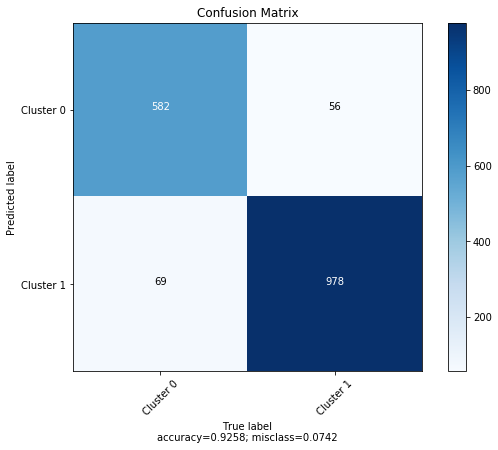

In [0]:
# Plot the confusion matrix of the cluster predictions
gmm_predictions = lr.predict(X_test)
confusion = confusion_matrix(y_test, gmm_predictions, labels=[0, 1])
plot_confusion_matrix(cm=confusion, target_names = ['Cluster 0', 'Cluster 1'], title = 'Confusion Matrix',normalize=False)

Between all of our models, the KMeans Model performed the best. In that model, the sihoutte score was equally as high as in the other models; however, it was also the most accurate model in prediciting an observation's cluster assignment, given its EmploymentStatus_Employed value. The KMeans model could predict an observation's cluster assignment with 98% accuracy based on just one variable which singlehandedly aacounted for 92% of the variance in the model.

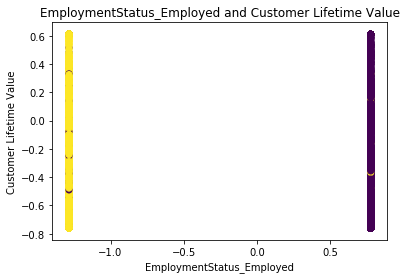

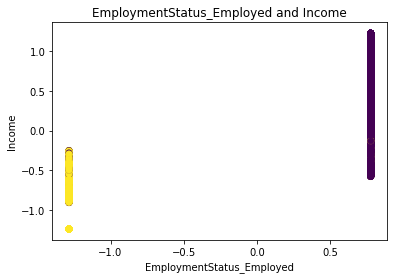

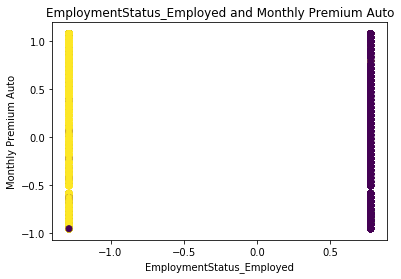

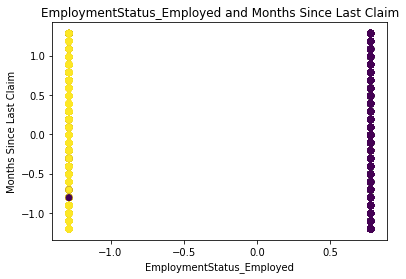

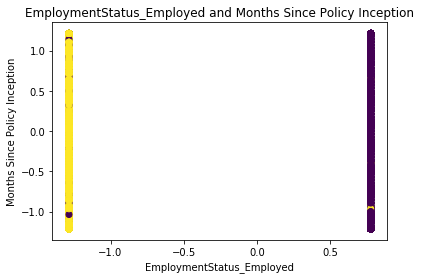

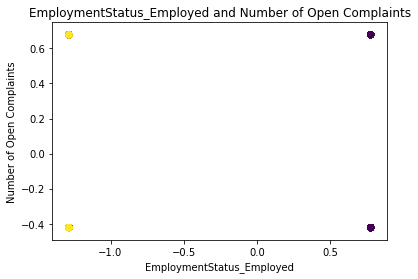

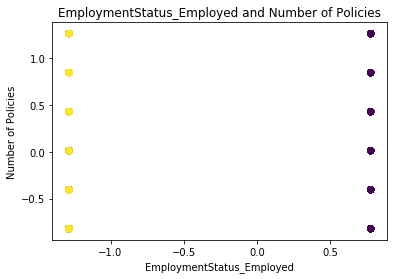

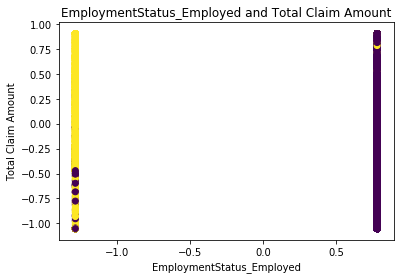

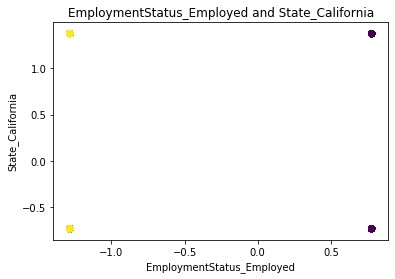

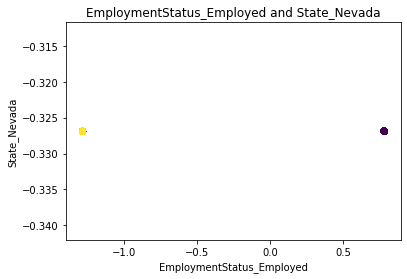

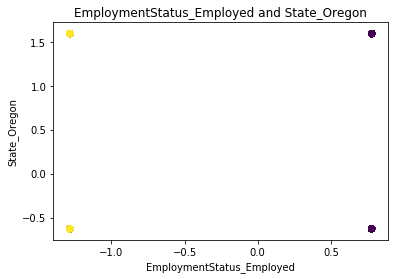

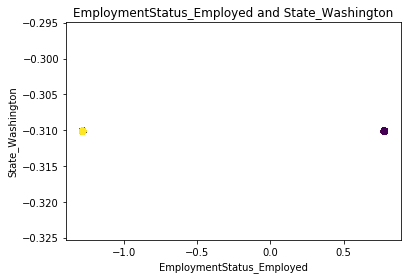

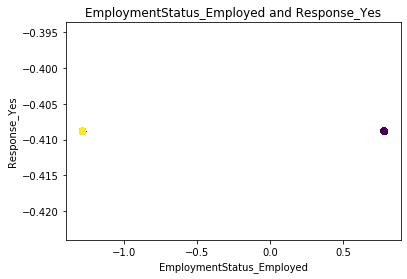

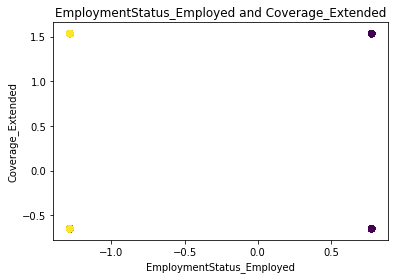

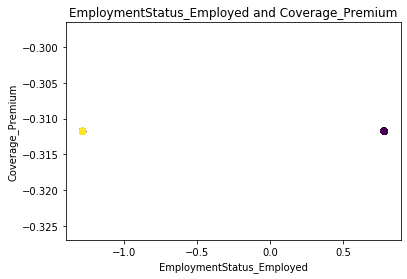

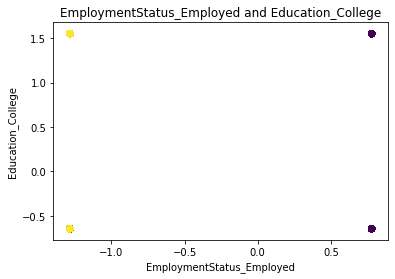

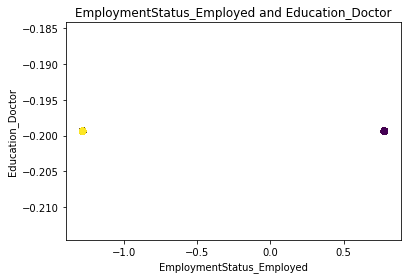

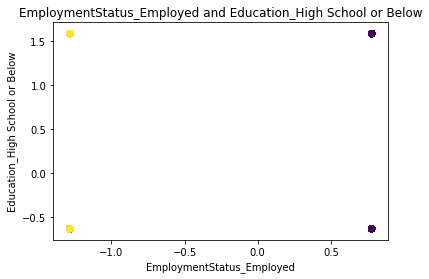

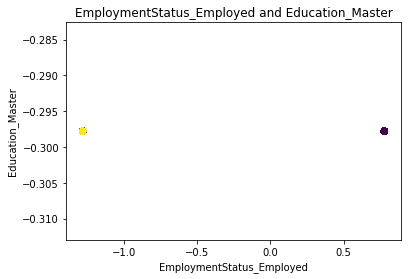

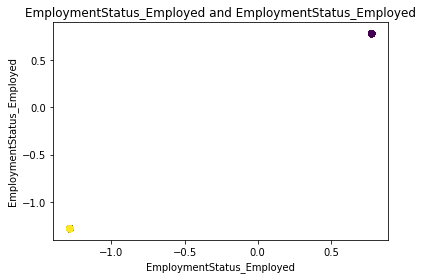

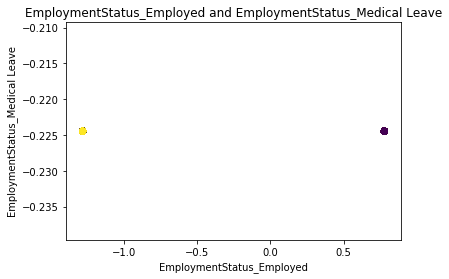

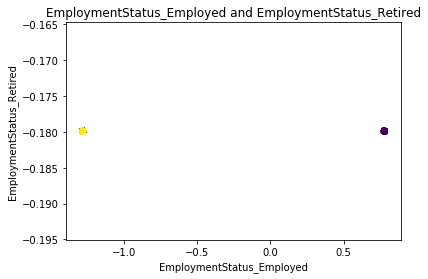

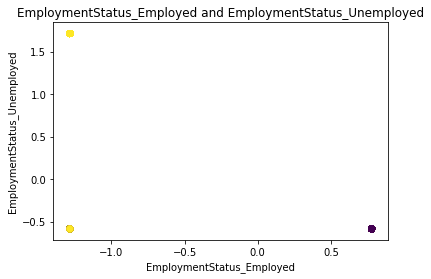

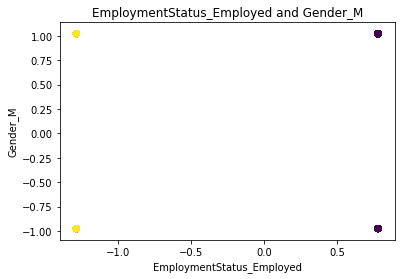

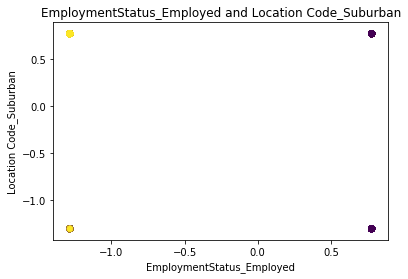

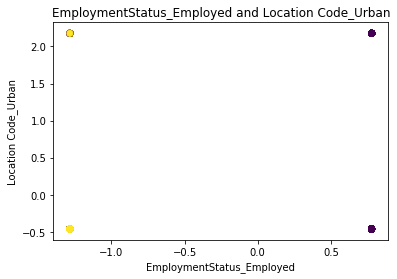

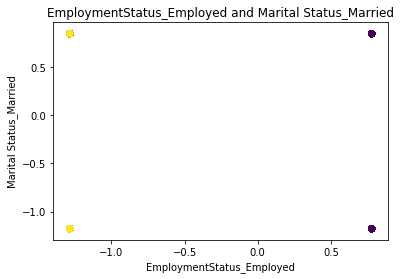

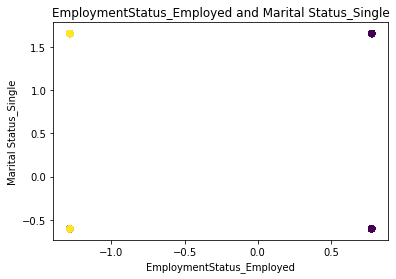

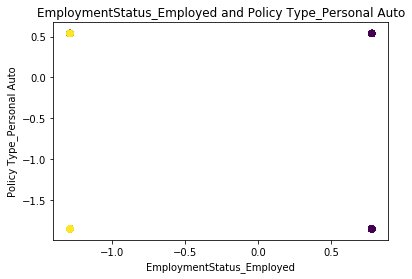

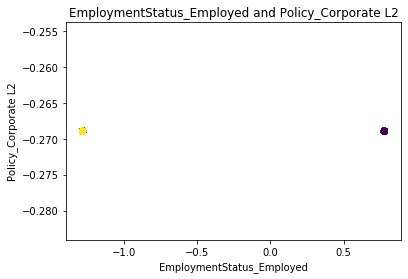

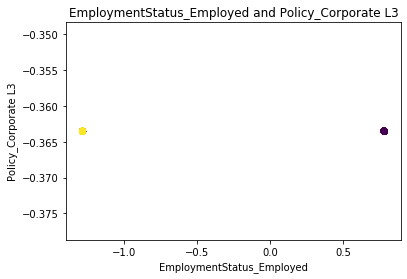

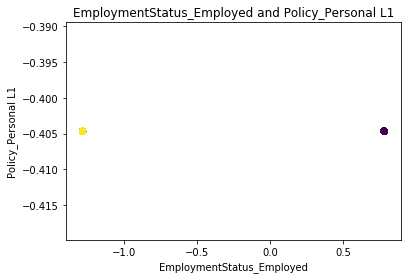

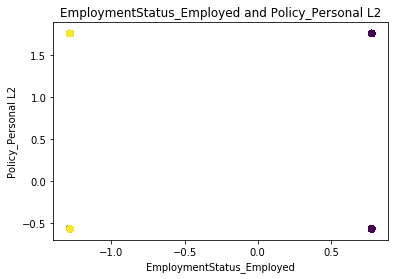

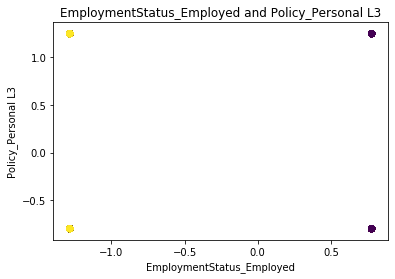

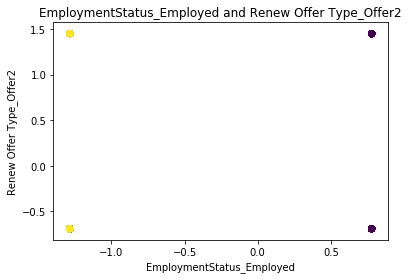

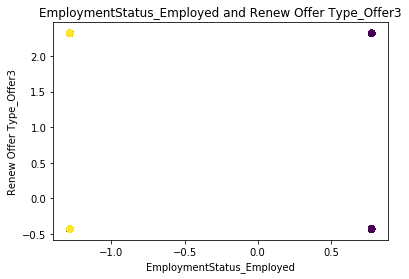

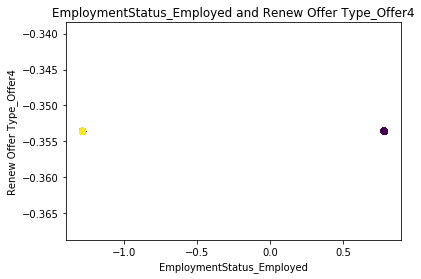

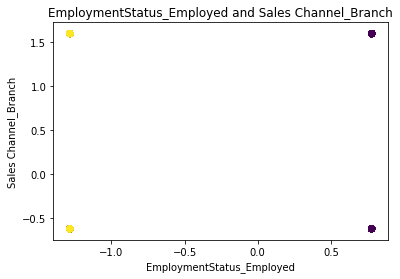

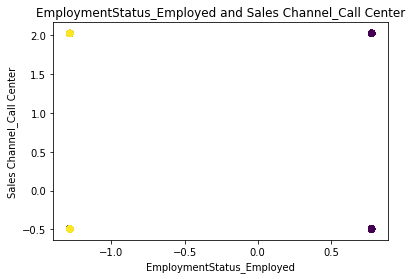

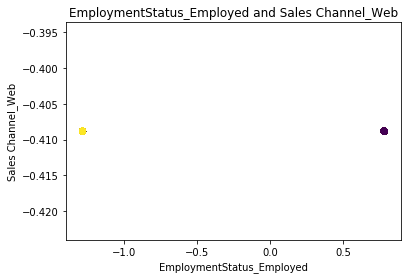

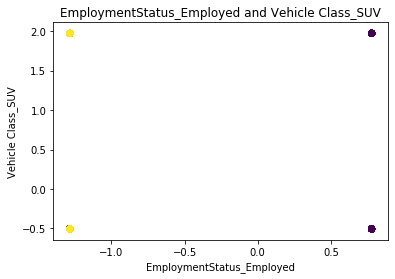

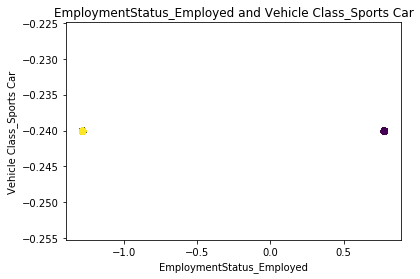

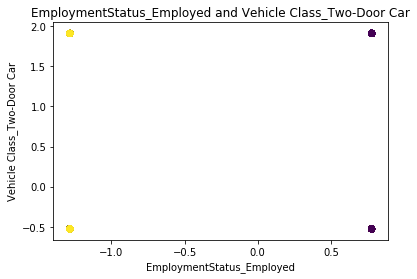

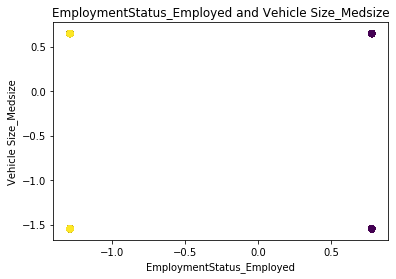

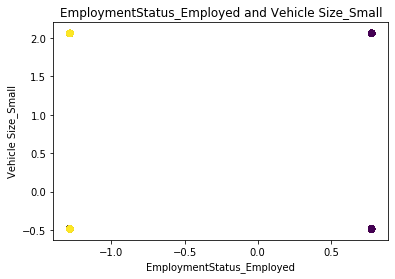

In [0]:
for column in df.columns:
  plt.scatter(df_with_kmeans['EmploymentStatus_Employed'], df_with_kmeans[column], c = df_with_kmeans['K Means Prediction'])
  plt.xlabel('EmploymentStatus_Employed')
  plt.ylabel(column)
  plt.title('EmploymentStatus_Employed and {}'.format(column))
  plt.show()

Since EmployedStatus_Employed was a dummy variable, the data represented in these images is rather descrete. However, it is clear that the observations which met this requirement (in other words, the employed observations) were almost always clustered together. The color of each observation is related to its cluster, however we see very few observations of differing colors on the same part of the graph. Althought I will lose a significant amount of variance within my dataframe, I will perform a PCA of componend 2 in order to further visualize this data. 

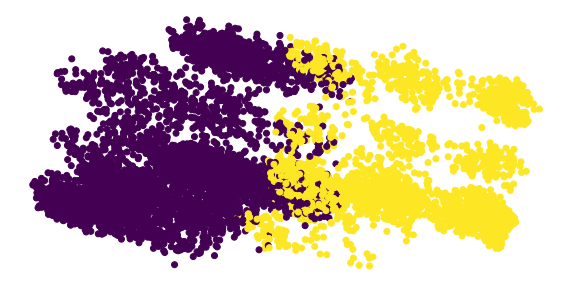

Only 0.19464249135344175 variance is retained by PCA of dimension 2


In [0]:
# Fit a PCA of 2 components to my dataset 
pca_components = PCA(n_components=2).fit_transform(df)

# Visualize the PCA and color each observation according to my best performing
# model, the KMeans with K=2 and No Batching
plt.figure(figsize=(10,5))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c = df_with_kmeans['K Means Prediction'])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

# Output how much variance is acutally retained by a PCA of dimension 2
print("Only {} variance is retained by PCA of dimension 2".format(pca.explained_variance_ratio_.sum()))

Although I lose a significant amount of variance within my dataset by using a PCA of dimension 2, this approach visualizes the two clusters within the dataset. The high level of overlap between both clusters in the middle of the visualization explains the rather weak silhoutette scores of .17. Due to the proximity of the clusters and encroachment of one cluster onto the other,the silhouette score was bound to be low.